<div style="text-align: center; font-family: Arial, sans-serif;">
    <h1>
        <a href="https://github.com/Franck-Dernoncourt/pubmed-rct" target="_blank" style="text-decoration: none; color: #2a7ae2;">
            Natural Language Processing - PubMed 200k RCT dataset
        </a>
    </h1>
    <h3>
        Also a TensorFlow Project from
        <a href="https://github.com/mrdbourke/tensorflow-deep-learning" target="_blank" style="text-decoration: none; color: #2a7ae2;">
            Mr. Bourke’s Deep Learning Course
        </a>
    </h3>
    <h4>By Mohammad Nourbakhsh Marvast</h4>
</div>

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import sklearn

In [2]:
import os
import random

# Loading Data

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 39.67 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [4]:
for dirpath, dirnames, filenames in os.walk("pubmed-rct"):
  print(dirpath)
  print(dirnames)
  print(filenames)
  print()
  print(15*'=')
  print()

pubmed-rct
['PubMed_20k_RCT', 'PubMed_20k_RCT_numbers_replaced_with_at_sign', 'PubMed_200k_RCT', 'PubMed_200k_RCT_numbers_replaced_with_at_sign', '.git']
['README.md']


pubmed-rct/PubMed_20k_RCT
[]
['dev.txt', 'test.txt', 'train.txt']


pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign
[]
['dev.txt', 'test.txt', 'train.txt']


pubmed-rct/PubMed_200k_RCT
[]
['dev.txt', 'train.7z', 'test.txt']


pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign
[]
['dev.txt', 'test.txt', 'train.zip']


pubmed-rct/.git
['refs', 'objects', 'branches', 'hooks', 'info', 'logs']
['config', 'HEAD', 'packed-refs', 'index', 'description']


pubmed-rct/.git/refs
['remotes', 'tags', 'heads']
[]


pubmed-rct/.git/refs/remotes
['origin']
[]


pubmed-rct/.git/refs/remotes/origin
[]
['HEAD']


pubmed-rct/.git/refs/tags
[]
[]


pubmed-rct/.git/refs/heads
[]
['master']


pubmed-rct/.git/objects
['pack', 'info']
[]


pubmed-rct/.git/objects/pack
[]
['pack-69d3b28149dd426fc10857b50ec224af8c35fa0c.idx', 'pack

In [5]:
def load_data(dirpath):
  data = {}
  for filename in os.listdir(dirpath):
    with open(os.path.join(dirpath, filename)) as f:
      data[filename.replace('.txt', '')] = f.readlines()
  return data

In [6]:
data = load_data('pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign')
print(data.keys())

dict_keys(['dev', 'test', 'train'])


In [7]:
for key in data.keys():
  print(f'{key}: {len(data[key])}')

dev: 35212
test: 35135
train: 210040


In [8]:
train_df = pd.Series(data['train']).str.lower().str.replace('\n', '').str.split('\t', expand= True)
test_df = pd.Series(data['test']).str.lower().str.replace('\n', '').str.split('\t', expand= True)
dev_df = pd.Series(data['dev']).str.lower().str.replace('\n', '').str.split('\t', expand= True)

def get_second_last(s):
  if len(s) >= 2:
    return s.iloc[-2]

abs_id = (train_df.iloc[:,0].str.contains('###')).cumsum()
train_df['line_number'] = train_df.groupby(abs_id).cumcount()
train_df['total_lines'] = train_df.groupby(abs_id)['line_number'].transform(get_second_last)

abs_id = (test_df.iloc[:,0].str.contains('###')).cumsum()
test_df['line_number'] = test_df.groupby(abs_id).cumcount()
test_df['total_lines'] = test_df.groupby(abs_id)['line_number'].transform(get_second_last)

abs_id = (dev_df.iloc[:,0].str.contains('###')).cumsum()
dev_df['line_number'] = dev_df.groupby(abs_id).cumcount()
dev_df['total_lines'] = dev_df.groupby(abs_id)['line_number'].transform(get_second_last)

train_df.columns = ['label', 'text', 'line_number', 'total_lines']
test_df.columns = ['label', 'text', 'line_number', 'total_lines']
dev_df.columns = ['label', 'text', 'line_number', 'total_lines']

train_df.dropna(inplace=True)
test_df.dropna(inplace=True)
dev_df.dropna(inplace=True)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
dev_df.reset_index(drop=True, inplace=True)

train_df.head(10)

,label,text,line_number,total_lines
0,objective,to investigate the efficacy of @ weeks of dail...,1,12
1,methods,a total of @ patients with primary knee oa wer...,2,12
2,methods,outcome measures included pain reduction and i...,3,12
3,methods,pain was assessed using the visual analog pain...,4,12
4,methods,secondary outcome measures included the wester...,5,12
5,methods,"serum levels of interleukin @ ( il-@ ) , il-@ ...",6,12
6,results,there was a clinically relevant reduction in t...,7,12
7,results,the mean difference between treatment arms ( @...,8,12
8,results,"further , there was a clinically relevant redu...",9,12
9,results,these differences remained significant at @ we...,10,12


In [9]:
def to_char_level(text):
    return ' '.join(list(text))

# Defining training sets for the models input
X_train_text = train_df['text'].to_numpy()
X_train_ln = train_df['line_number'].to_numpy()
X_train_tl = train_df['total_lines'].to_numpy()
X_train_char = [to_char_level(s) for s in X_train_text]

# Defining validation sets for the models input
X_val_text = dev_df['text'].to_numpy()
X_val_ln = dev_df['line_number'].to_numpy()
X_val_tl = dev_df['total_lines'].to_numpy()
X_val_char = [to_char_level(s) for s in X_val_text]

# Defining testing sets for the models evaluation
X_test_text = test_df['text'].to_numpy()
X_test_ln = test_df['line_number'].to_numpy()
X_test_tl = test_df['total_lines'].to_numpy()
X_test_char = [to_char_level(s) for s in X_test_text]

In [10]:
# Getting the labels ready - Label Encoding into integers:
label_encoder = sklearn.preprocessing.LabelEncoder()

y_train = label_encoder.fit_transform(train_df['label'])
y_val = label_encoder.transform(dev_df['label'])
y_test = label_encoder.transform(test_df['label'])

In [11]:
import string
# Max lenght of the sentences in consideration:
MAX_LEN_TEXT = int(np.percentile([len(sentence.split()) for sentence in X_train_text],95))
MAX_LEN_CHAR = int(np.percentile([len(sentence) for sentence in X_train_text],95))
MAX_NUM_LINES = int(np.percentile(X_train_ln,95))
MAX_TOTAL_LINES = int(np.percentile(X_train_tl, 95))

CHAR_VOCAB = list(string.ascii_lowercase + string.digits + string.punctuation)
MAX_ALPHABET_LEN = len(CHAR_VOCAB) + 2  # +2 for padding and OOV

In [12]:
CLASS_NAMES = label_encoder.classes_
CLASS_NAMES

array(['background', 'conclusions', 'methods', 'objective', 'results'],
      dtype=object)

# Visualize, Visualize, Visualize!

In [13]:
rnd_id = random.sample(train_df.index.tolist(), 5)

for i in rnd_id:
  print(f'True Label= {train_df.loc[i, "label"]}:\n{train_df.loc[i, "text"]}')
  print()
  print(15*'=')
  print()

True Label= methods:
infants received @min of moderate pressure massage or passive flexion and extension of the limbs @ times per day for @days , and ekgs were collected during the first session to assess vagal activity .


True Label= results:
allele-specific efficacy seen in the first malaria season did not extend into the second season of follow-up .


True Label= results:
( @ ) anal temperature ( at ) was lowered during training , while the change of mean skin temperature ( mst ) was not significant .


True Label= results:
five hhri were revised , and in the interval before the last follow-up ( revision or @ years ) , tt of @ mm ( sd , @ mm ) for revised hhri was higher ( p = @ ) than tt of @ mm ( sd , @ mm ) in nonrevised hhri .


True Label= results:
both evl and carvedilol groups had comparable variceal bleeding rates ( @ % vs. @ % ) , bleed related mortality ( @ % vs. @ % ) and overall mortality ( @ % vs. @ % ) respectively .




# Model 0: Naive Bayes Classification

In [14]:
model0 = sklearn.pipeline.Pipeline([
    ('tfidf', sklearn.feature_extraction.text.TfidfVectorizer()),
    ('clf', sklearn.naive_bayes.MultinomialNB())
])

model0.fit(X_train_text, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

## Model Evaluation

In [15]:
model0.score(X_val_text, y_val)

0.7218323844829869

In [16]:
X_pred = model0.predict(X_val_text)

In [17]:
def evaluate_model(y_true, y_pred, class_names):
    classification_report = sklearn.metrics.classification_report(
        y_true, y_pred, target_names=class_names
    )

    print('\n====================')
    print('Classification Report')
    print('====================')

    print(classification_report)

    # Confusion Matrix

    print('\n====================')
    print('Confusion Matrix')
    print('====================')

    confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)

    accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
    precision = sklearn.metrics.precision_score(y_true, y_pred, average='weighted')
    recall = sklearn.metrics.recall_score(y_true, y_pred, average='weighted')
    f1_score = sklearn.metrics.f1_score(y_true, y_pred, average='weighted')

    disp = sklearn.metrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix,
        display_labels=class_names
    )

    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap='PuBu', values_format='d')
    ax.set_title(
        f'Confusion Matrix\nAccuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1_Score: {f1_score:.2f}'
    )
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    print('====================\n')

    return {'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score}


Classification Report
              precision    recall  f1-score   support

  background       0.66      0.49      0.56      3449
 conclusions       0.65      0.59      0.61      4582
     methods       0.72      0.87      0.79      9964
   objective       0.75      0.14      0.23      2376
     results       0.76      0.86      0.81      9841

    accuracy                           0.72     30212
   macro avg       0.71      0.59      0.60     30212
weighted avg       0.72      0.72      0.70     30212


Confusion Matrix


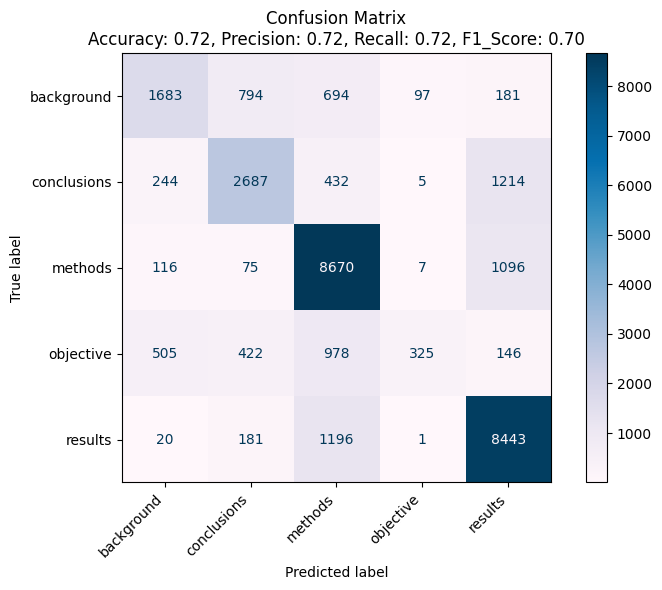

In [18]:
model0_result_val= evaluate_model(y_val, X_pred, class_names= CLASS_NAMES)

## Model Prediction

In [19]:
model0_pred = model0.predict(X_test_text)


Classification Report
              precision    recall  f1-score   support

  background       0.65      0.47      0.54      3621
 conclusions       0.63      0.58      0.60      4571
     methods       0.72      0.88      0.79      9897
   objective       0.74      0.13      0.22      2333
     results       0.76      0.85      0.80      9713

    accuracy                           0.72     30135
   macro avg       0.70      0.58      0.59     30135
weighted avg       0.71      0.72      0.69     30135


Confusion Matrix


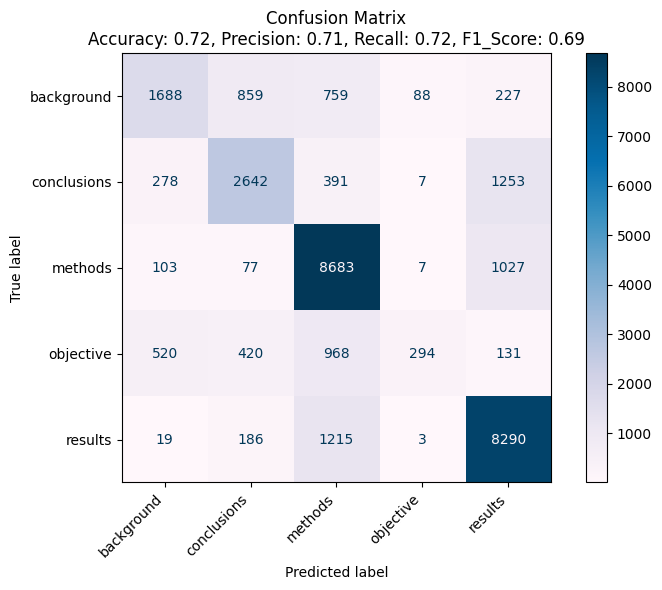

In [20]:
model0_results = evaluate_model(y_test, model0_pred, class_names= CLASS_NAMES)

In [21]:
rnd_id = random.sample(test_df.index.tolist(), 5)

for i in rnd_id:
  print(f'True Label= {test_df.loc[i, "label"]}\nPred Label= {label_encoder.inverse_transform([model0_pred[i]])[0]}\n{test_df.loc[i, "text"]}')
  print()
  print(15*'=')
  print()

True Label= methods
Pred Label= methods
the mean arterial pressure ( map ) , heart rate ( hr ) and pulse oxygen saturation ( spo@ ) were measured and recorded by monitor during the operation .


True Label= methods
Pred Label= methods
a total of @ patients planned for an elective shunting procedure will be enrolled throughout @ study centres within two years .


True Label= conclusions
Pred Label= results
ve was higher in children than in infants , but even at modest levels of ve , the number of malaria cases averted was substantial .


True Label= results
Pred Label= results
fingolimod reduced bv loss over @ months versus ifn-@a im in all patient subgroups assessed , including individuals with or without gadolinium ( gd ) - enhancing lesions at baseline .


True Label= methods
Pred Label= methods
in partogram group , progress of labour was documented on modified who partograph along with the notes on progress sheet of case record file while by standard notes only in no partogram group

# Initiate CallBacks

In [22]:
import datetime

class ModelCallbacks:
    """
    A utility class for creating and managing common Keras training callbacks:
    - TensorBoard logging
    - Model checkpointing
    - Early stopping

    Attributes:
        tensorboard_callback (tf.keras.callbacks.TensorBoard): Callback for logging to TensorBoard.
        checkpoint_callback (tf.keras.callbacks.ModelCheckpoint): Callback for saving model checkpoints.
        early_stopping_callback (tf.keras.callbacks.EarlyStopping): Callback for early stopping during training.
    """

    def __init__(self, verbose=True):
        """
        Initialize the callback container.

        Args:
            verbose (bool): Whether to print status messages during setup.
        """
        self.tensorboard_callback = None
        self.checkpoint_callback = None
        self.early_stopping_callback = None
        self.verbose = verbose

    def tensorboard(self, dir_name, experiment_name):
        """
        Create and store a TensorBoard callback.

        Args:
            dir_name (str): Root directory where logs should be saved.
            experiment_name (str): Subfolder name to distinguish experiments.
        """
        log_dir = os.path.join(
            dir_name,
            experiment_name,
            datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        )
        self.tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

        if self.verbose:
            print(f"[TensorBoard] Log files will be saved to: {log_dir}")

    def checkpoint(self, dir_name, experiment_name, save_best_only=True, monitor='val_loss'):
        """
        Create and store a model checkpoint callback that saves only weights.

        Args:
            filepath (str): Filepath where the weights will be saved.
            save_best_only (bool): Whether to save only the best model (based on monitored metric).
            monitor (str): Metric to monitor for determining the best model.
        """
        # Creating a filepath
        filepath= os.path.join(
            dir_name,
            experiment_name,
            datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'.weights.h5'
        )

        # Make sure the directory exists
        os.makedirs(os.path.dirname(filepath), exist_ok=True)

        self.checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=filepath,
            save_weights_only=True,  # <== Only weights, not full model
            save_best_only=save_best_only,
            monitor=monitor,
            verbose=1 if self.verbose else 0
        )
        if self.verbose:
            print(f"[Checkpoint] Saving only weights to: {filepath} (monitoring '{monitor}')")

    def early_stopping(self, patience=5, monitor='val_loss', restore_best_weights=True):
        """
        Create and store an early stopping callback.

        Args:
            patience (int): Number of epochs to wait for improvement before stopping.
            monitor (str): Metric to monitor for improvement.
            restore_best_weights (bool): Whether to restore model weights from the epoch with the best value of the monitored quantity.
        """
        self.early_stopping_callback = tf.keras.callbacks.EarlyStopping(
            patience=patience,
            monitor=monitor,
            restore_best_weights=restore_best_weights,
            verbose=1 if self.verbose else 0
        )
        if self.verbose:
            print(f"[EarlyStopping] Will stop if no improvement in '{monitor}' for {patience} epochs.")

    def get_callbacks(self):
        """
        Collect and return a list of all non-None callbacks.

        Returns:
            list: A list of keras.callbacks instances.
        """
        return [
            cb for cb in [
                self.tensorboard_callback,
                self.checkpoint_callback,
                self.early_stopping_callback
            ] if cb is not None
        ]

In [23]:
DIR_NAME = "TensorBoard"

# Model 1: Feed-Forward Neural Network

## Building Up The Model

In [24]:
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=68000,
                                                    standardize='lower_and_strip_punctuation',
                                                    split='whitespace',
                                                    output_sequence_length=MAX_LEN_TEXT,
                                                    ngrams=None)

text_vectorizer.adapt(X_train_text)

In [25]:
vocab_size = len(text_vectorizer.get_vocabulary())
embedding_layer_text = tf.keras.layers.Embedding(input_dim= vocab_size,
                                                 output_dim= 128,
                                                 name= 'TokenEmbeddingLayer')

In [26]:
input = tf.keras.layers.Input(shape=(), dtype=tf.string)
x = text_vectorizer(input)
x = embedding_layer_text(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')(x)

model1 = tf.keras.Model(inputs=input, outputs=output, name= 'model1_FFNN')

model1.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer= tf.keras.optimizers.Adam(clipnorm=1.0),
               metrics = ['accuracy'])

model1.summary()

Model: "model1_FFNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ TokenEmbeddingLayer (Embedding) │ (None, 55, 128)        │     8,299,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,310,149 (31.70 MB)

 Trainable params: 8,310,149 (31.70 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
callback = ModelCallbacks(verbose=True)
callback.tensorboard(dir_name=DIR_NAME, experiment_name='model1_FFNN')
callback.early_stopping(patience=5)

model1_callbacks = callback.get_callbacks()

[TensorBoard] Log files will be saved to: TensorBoard/model1_FFNN/20250705-104918
[EarlyStopping] Will stop if no improvement in 'val_loss' for 5 epochs.


In [28]:
model1_train_input = (
    tf.data.Dataset.from_tensor_slices((X_train_text, y_train))
    ).batch(32).prefetch(tf.data.AUTOTUNE)

model1_val_input = (
    tf.data.Dataset.from_tensor_slices((X_val_text, y_val))
    ).batch(32).prefetch(tf.data.AUTOTUNE)

model1_test_input = (
    tf.data.Dataset.from_tensor_slices(X_test_text)
    ).batch(32).prefetch(tf.data.AUTOTUNE)


model1_history = model1.fit(model1_train_input,
                            epochs=3,
                            steps_per_epoch= int(0.05*len(model1_train_input)),
                            validation_data= model1_val_input,
                            validation_steps= int(0.05*len(model1_val_input)),
                            callbacks= model1_callbacks)

Epoch 1/3
281/281 ━━━━━━━━━━━━━━━━━━━━ 24s 75ms/step - accuracy: 0.3463 - loss: 1.4475 - val_accuracy: 0.6137 - val_loss: 0.9740
Epoch 2/3
281/281 ━━━━━━━━━━━━━━━━━━━━ 41s 146ms/step - accuracy: 0.5946 - loss: 0.9514 - val_accuracy: 0.6562 - val_loss: 0.8171
Epoch 3/3
281/281 ━━━━━━━━━━━━━━━━━━━━ 41s 146ms/step - accuracy: 0.6673 - loss: 0.8199 - val_accuracy: 0.6430 - val_loss: 0.8202
Restoring model weights from the end of the best epoch: 2.


## Model Evaluation

In [29]:
model1.evaluate(model1_val_input)

945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6621 - loss: 0.8059


[0.8026856780052185, 0.663941502571106]

In [30]:
X_pred = model1.predict(model1_val_input)
X_pred = np.argmax(X_pred, axis=1)

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step



Classification Report
              precision    recall  f1-score   support

  background       0.37      0.72      0.49      3449
 conclusions       0.59      0.33      0.42      4582
     methods       0.69      0.95      0.80      9964
   objective       0.20      0.00      0.00      2376
     results       0.91      0.68      0.77      9841

    accuracy                           0.66     30212
   macro avg       0.55      0.53      0.50     30212
weighted avg       0.67      0.66      0.64     30212


Confusion Matrix


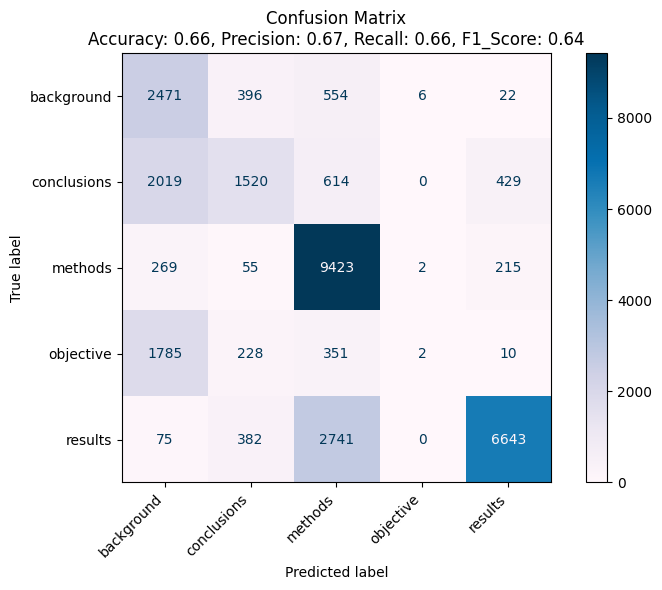

In [31]:
model1_result_val= evaluate_model(y_val, X_pred, class_names= CLASS_NAMES)

## Model Prediction

In [32]:
model1_pred = model1.predict(model1_test_input)
model1_pred = np.argmax(model1_pred, axis=1)

942/942 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step



Classification Report
              precision    recall  f1-score   support

  background       0.39      0.72      0.50      3621
 conclusions       0.59      0.32      0.42      4571
     methods       0.69      0.94      0.79      9897
   objective       0.00      0.00      0.00      2333
     results       0.90      0.67      0.77      9713

    accuracy                           0.66     30135
   macro avg       0.51      0.53      0.50     30135
weighted avg       0.65      0.66      0.63     30135


Confusion Matrix


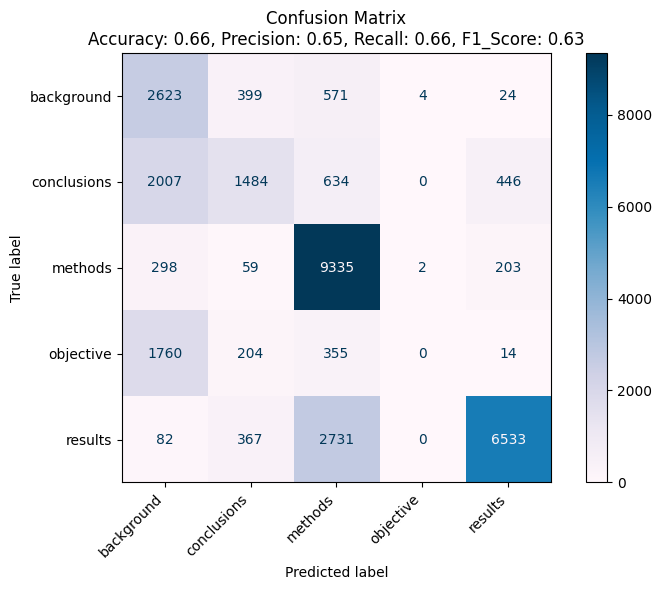

In [33]:
model1_results = evaluate_model(y_test, model1_pred, class_names= CLASS_NAMES)

In [34]:
rnd_id = random.sample(test_df.index.tolist(), 5)

for i in rnd_id:
  print(f'True Label= {test_df.loc[i, "label"]}\nPred Label= {label_encoder.inverse_transform([model1_pred[i]])[0]}\n{test_df.loc[i, "text"]}')
  print()
  print(15*'=')
  print()

True Label= conclusions
Pred Label= background
use of a single injection of double-dose contrast medium and longer delay time may improve margin delineation of lesions for the study of brain metastasis .


True Label= results
Pred Label= methods
moderate pain was slightly more frequent in the group who used bupivacaine .


True Label= background
Pred Label= background
the evidence for effective worker-directed interventions for employees with depressive symptoms is limited .


True Label= results
Pred Label= results
pads per day change from baseline was -@ and -@ , respectively ( p = @ ) .


True Label= objective
Pred Label= background
we aimed to investigate the effects of the oxymizer on endurance time in comparison to a conventional nasal cannula ( cnc ) .




# Model 2: RNN - LSTM Layer

## Building Up The Model

In [35]:
input = tf.keras.layers.Input(shape=(), dtype=tf.string)
x = text_vectorizer(input)
x = embedding_layer_text(x)
x = tf.keras.layers.LSTM(64, return_sequences=True)(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')(x)

model2 = tf.keras.Model(inputs=input, outputs=output, name= 'model2_RNNLSTM')

model2.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer= tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])

model2.summary()

Model: "model2_RNNLSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ TokenEmbeddingLayer (Embedding) │ (None, 55, 128)        │     8,299,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 55, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,355,461 (31.87 MB)

 Trainable params: 8,355,461 (31.87 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
callback = ModelCallbacks(verbose=True)
callback.tensorboard(dir_name=DIR_NAME, experiment_name='model2_RNNLSTM')
callback.early_stopping(patience=5)

model2_callbacks = callback.get_callbacks()

[TensorBoard] Log files will be saved to: TensorBoard/model2_RNNLSTM/20250705-105154
[EarlyStopping] Will stop if no improvement in 'val_loss' for 5 epochs.


In [37]:
model2_train_input = (
    tf.data.Dataset.from_tensor_slices((X_train_text, y_train))
    ).batch(32).prefetch(tf.data.AUTOTUNE)

model2_val_input = (
    tf.data.Dataset.from_tensor_slices((X_val_text, y_val))
    ).batch(32).prefetch(tf.data.AUTOTUNE)

model2_test_input = (
    tf.data.Dataset.from_tensor_slices(X_test_text)
    ).batch(32).prefetch(tf.data.AUTOTUNE)


model2_history = model2.fit(model2_train_input,
                            epochs=3,
                            steps_per_epoch= int(0.05*len(model2_train_input)),
                            validation_data= model2_val_input,
                            validation_steps= int(0.05*len(model2_val_input)),
                            callbacks= model2_callbacks)

Epoch 1/3
281/281 ━━━━━━━━━━━━━━━━━━━━ 35s 110ms/step - accuracy: 0.6011 - loss: 1.0910 - val_accuracy: 0.7487 - val_loss: 0.6947
Epoch 2/3
281/281 ━━━━━━━━━━━━━━━━━━━━ 34s 120ms/step - accuracy: 0.7653 - loss: 0.6398 - val_accuracy: 0.7713 - val_loss: 0.6318
Epoch 3/3
281/281 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - accuracy: 0.7604 - loss: 0.6807 - val_accuracy: 0.7739 - val_loss: 0.5924
Restoring model weights from the end of the best epoch: 3.


## Model Evaluation

In [38]:
model2.evaluate(model2_val_input)

945/945 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.7833 - loss: 0.5862


[0.5884309411048889, 0.7828015089035034]

In [39]:
X_pred = model2.predict(model2_val_input)
X_pred = np.argmax(X_pred, axis=1)

945/945 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step



Classification Report
              precision    recall  f1-score   support

  background       0.54      0.66      0.60      3449
 conclusions       0.69      0.66      0.68      4582
     methods       0.85      0.89      0.87      9964
   objective       0.76      0.49      0.59      2376
     results       0.86      0.85      0.85      9841

    accuracy                           0.78     30212
   macro avg       0.74      0.71      0.72     30212
weighted avg       0.79      0.78      0.78     30212


Confusion Matrix


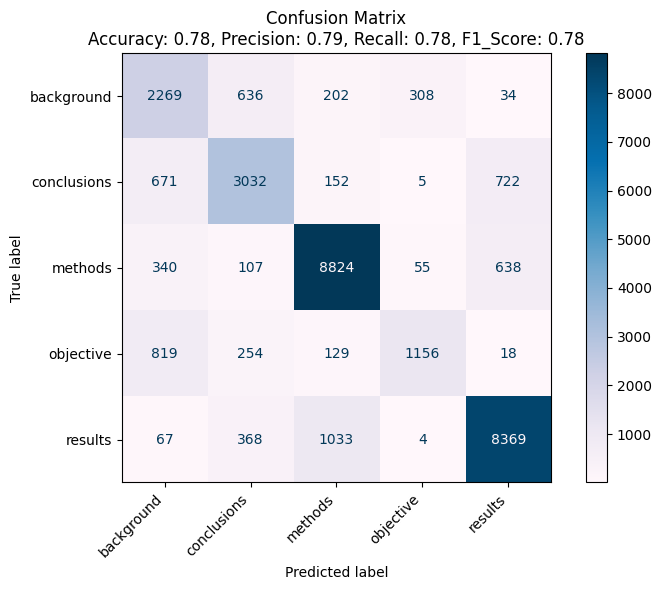

In [40]:
model2_result_val= evaluate_model(y_val, X_pred, class_names= CLASS_NAMES)

## Model Prediction

In [41]:
model2_pred = model2.predict(model2_test_input)
model2_pred = np.argmax(model2_pred, axis=1)

942/942 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step



Classification Report
              precision    recall  f1-score   support

  background       0.55      0.65      0.60      3621
 conclusions       0.68      0.65      0.67      4571
     methods       0.85      0.89      0.87      9897
   objective       0.73      0.48      0.58      2333
     results       0.85      0.84      0.85      9713

    accuracy                           0.78     30135
   macro avg       0.73      0.70      0.71     30135
weighted avg       0.78      0.78      0.78     30135


Confusion Matrix


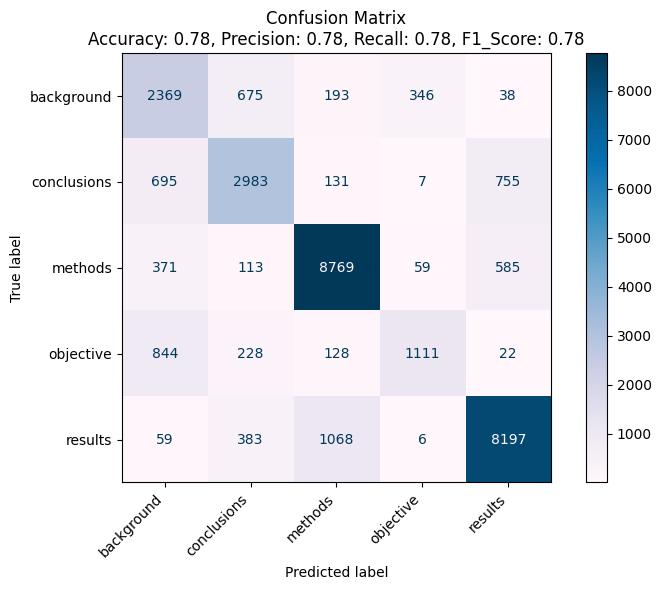

In [42]:
model2_results = evaluate_model(y_test, model2_pred, class_names= CLASS_NAMES)

In [43]:
rnd_id = random.sample(test_df.index.tolist(), 5)

for i in rnd_id:
  print(f'True Label= {test_df.loc[i, "label"]}\nPred Label= {label_encoder.inverse_transform([model2_pred[i]])[0]}\n{test_df.loc[i, "text"]}')
  print()
  print(15*'=')
  print()

True Label= results
Pred Label= results
after @months , a significant crestal bone loss was observed for emd ( @ mm ; p = @ ) but not for ofd ( @ mm ; p = @ ) .


True Label= methods
Pred Label= methods
assessments will be made at baseline and at one , three and five weeks thereafter ( that is , the five-week assessment will be made two weeks after treatment cessation ) .


True Label= methods
Pred Label= background
we describe five steps in our intervention design : formative research , review of existing evidence and theory , a workshop to define the intervention approach and content and results of formative research , engagement with behaviour change theory and literature , detailed design of intervention materials and piloting and pretesting of intervention materials .


True Label= results
Pred Label= results
a high antibody response of igm and igg isotype against the neugcgm@ ganglioside was obtained .


True Label= results
Pred Label= conclusions
pre-alert data demonstrated a st

# Model 3: RNN - GRU Layer

## Building Up The Model

In [44]:
input = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(input)
x = embedding_layer_text(x)
x = tf.keras.layers.GRU(64, return_sequences=True)(x)
x = tf.keras.layers.LSTM(64, return_sequences=True)(x)
x = tf.keras.layers.GRU(64, return_sequences=True)(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')(x)

model3 = tf.keras.models.Model(inputs=input, outputs=output, name= 'model3_RNNGRU')

model3.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer= tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])

model3.summary()

Model: "model3_RNNGRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ TokenEmbeddingLayer (Embedding) │ (None, 55, 128)        │     8,299,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 55, 64)         │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 55, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 55, 64)         │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,401,285 (32.05 MB)

 Trainable params: 8,401,285 (32.05 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
callback = ModelCallbacks(verbose=True)
callback.tensorboard(dir_name=DIR_NAME, experiment_name='model3_RNNGRU')
callback.early_stopping(patience=5)

model3_callbacks = callback.get_callbacks()

[TensorBoard] Log files will be saved to: TensorBoard/model3_RNNGRU/20250705-105412
[EarlyStopping] Will stop if no improvement in 'val_loss' for 5 epochs.


In [46]:
model3_train_input = (
    tf.data.Dataset.from_tensor_slices((X_train_text, y_train))
    ).batch(32).prefetch(tf.data.AUTOTUNE)

model3_val_input = (
    tf.data.Dataset.from_tensor_slices((X_val_text, y_val))
    ).batch(32).prefetch(tf.data.AUTOTUNE)

model3_test_input = (
    tf.data.Dataset.from_tensor_slices(X_test_text)
    ).batch(32).prefetch(tf.data.AUTOTUNE)


model3_history = model3.fit(model3_train_input,
                            epochs=3,
                            steps_per_epoch= int(0.05*len(model3_train_input)),
                            validation_data= model3_val_input,
                            validation_steps= int(0.05*len(model3_val_input)),
                            callbacks= model3_callbacks)


Epoch 1/3
281/281 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - accuracy: 0.5930 - loss: 1.0148 - val_accuracy: 0.7320 - val_loss: 0.6917
Epoch 2/3
281/281 ━━━━━━━━━━━━━━━━━━━━ 82s 292ms/step - accuracy: 0.7962 - loss: 0.5464 - val_accuracy: 0.7434 - val_loss: 0.6753
Epoch 3/3
281/281 ━━━━━━━━━━━━━━━━━━━━ 82s 292ms/step - accuracy: 0.8047 - loss: 0.5577 - val_accuracy: 0.7726 - val_loss: 0.6139
Restoring model weights from the end of the best epoch: 3.


## Model Evaluation

In [47]:
model3.evaluate(model3_val_input)

945/945 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.7737 - loss: 0.6140


[0.6199098229408264, 0.7728385925292969]

In [48]:
X_pred = model3.predict(model3_val_input)
X_pred = np.argmax(X_pred, axis=1)

945/945 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step



Classification Report
              precision    recall  f1-score   support

  background       0.52      0.67      0.59      3449
 conclusions       0.71      0.61      0.66      4582
     methods       0.86      0.86      0.86      9964
   objective       0.70      0.49      0.58      2376
     results       0.83      0.86      0.85      9841

    accuracy                           0.77     30212
   macro avg       0.72      0.70      0.71     30212
weighted avg       0.78      0.77      0.77     30212


Confusion Matrix


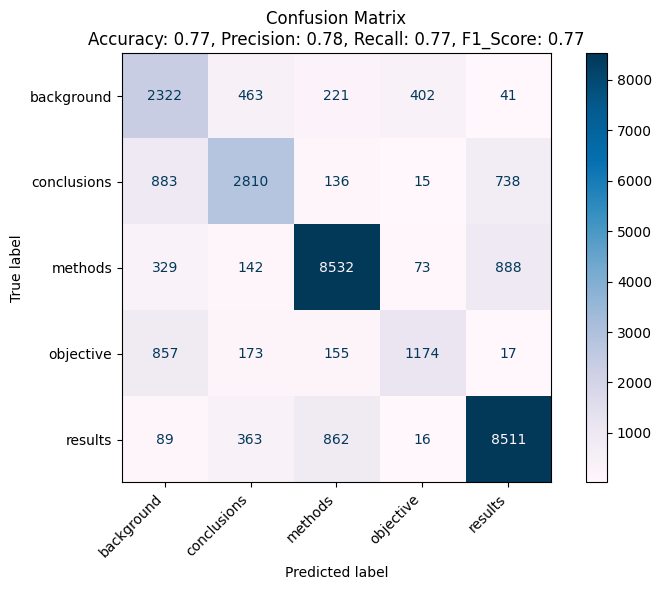

In [49]:
model3_result_val= evaluate_model(y_val, X_pred, class_names= CLASS_NAMES)

## Model Prediction

In [50]:
model3_pred = model3.predict(model3_test_input)
model3_pred = np.argmax(model3_pred, axis=1)

942/942 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step



Classification Report
              precision    recall  f1-score   support

  background       0.53      0.68      0.59      3621
 conclusions       0.70      0.61      0.65      4571
     methods       0.86      0.86      0.86      9897
   objective       0.68      0.47      0.56      2333
     results       0.84      0.86      0.85      9713

    accuracy                           0.77     30135
   macro avg       0.72      0.70      0.70     30135
weighted avg       0.77      0.77      0.77     30135


Confusion Matrix


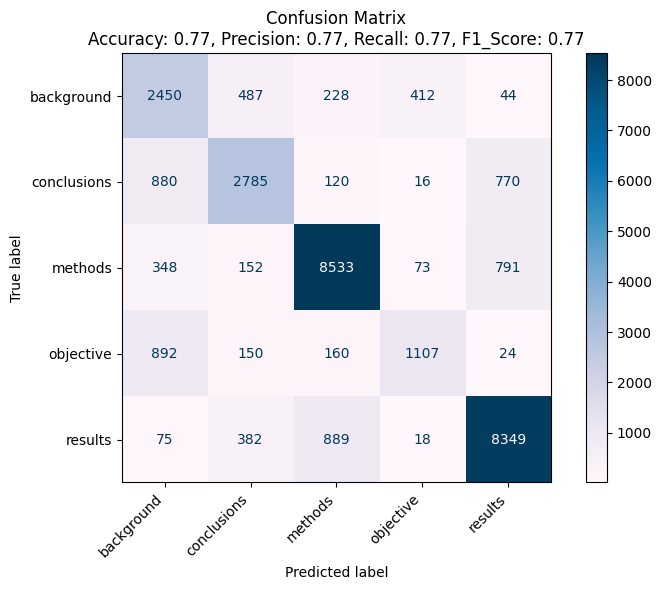

In [51]:
model3_results = evaluate_model(y_test, model3_pred, class_names= CLASS_NAMES)

In [52]:
rnd_id = random.sample(test_df.index.tolist(), 5)

for i in rnd_id:
  print(f'True Label= {test_df.loc[i, "label"]}\nPred Label= {label_encoder.inverse_transform([model3_pred[i]])[0]}\n{test_df.loc[i, "text"]}')
  print()
  print(15*'=')
  print()

True Label= conclusions
Pred Label= conclusions
the long-term efficacy of platelet concentrate combined with a barrier membrane is similar with the combination of bioactive glass graft material and barrier membrane , suggesting that results obtained with both treatment approaches can be maintained over a period of @ years .


True Label= results
Pred Label= conclusions
dietary intervention had no obvious effect on long-term gastrointestinal symptoms or hrqol .


True Label= background
Pred Label= background
unique identifier : nct@ .


True Label= conclusions
Pred Label= background
guided imagery relaxation therapy could be incorporated as part of fibromyalgia treatment to promote health among people with fibromyalgia .


True Label= methods
Pred Label= methods
for the study , @ patients with pt@-@pn@ prostate cancer with positive or negative surgical margins were recruited .




# Model 4: RNN - Using Bidirectional Layers

## Building Up The Model

In [53]:
input = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(input)
x = embedding_layer_text(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True))(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')(x)

model4 = tf.keras.models.Model(inputs=input, outputs=output, name= 'model4_RNNBidirectional')

model4.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer= tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])

model4.summary()

Model: "model4_RNNBidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ TokenEmbeddingLayer (Embedding) │ (None, 55, 128)        │     8,299,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 55, 128)        │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 55, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 55, 128)        │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,557,957 (32.65 MB)

 Trainable params: 8,557,957 (32.65 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
callback = ModelCallbacks(verbose=True)
callback.tensorboard(dir_name=DIR_NAME, experiment_name='model4_RNNBidirectional')
callback.early_stopping(patience=5)

model4_callbacks = callback.get_callbacks()

[TensorBoard] Log files will be saved to: TensorBoard/model4_RNNBidirectional/20250705-105933
[EarlyStopping] Will stop if no improvement in 'val_loss' for 5 epochs.


In [55]:
model4_train_input = (
    tf.data.Dataset.from_tensor_slices((X_train_text, y_train))
    ).batch(32).prefetch(tf.data.AUTOTUNE)

model4_val_input = (
    tf.data.Dataset.from_tensor_slices((X_val_text, y_val))
    ).batch(32).prefetch(tf.data.AUTOTUNE)

model4_test_input = (
    tf.data.Dataset.from_tensor_slices(X_test_text)
    ).batch(32).prefetch(tf.data.AUTOTUNE)

model4_history = model4.fit(model4_train_input,
                            epochs=3,
                            steps_per_epoch= int(0.05*len(model4_train_input)),
                            validation_data= model4_val_input,
                            validation_steps= int(0.05*len(model4_val_input)),
                            callbacks= model4_callbacks)

Epoch 1/3
281/281 ━━━━━━━━━━━━━━━━━━━━ 90s 272ms/step - accuracy: 0.5950 - loss: 0.9993 - val_accuracy: 0.7480 - val_loss: 0.7473
Epoch 2/3
281/281 ━━━━━━━━━━━━━━━━━━━━ 82s 292ms/step - accuracy: 0.8347 - loss: 0.4754 - val_accuracy: 0.7633 - val_loss: 0.6724
Epoch 3/3
281/281 ━━━━━━━━━━━━━━━━━━━━ 82s 291ms/step - accuracy: 0.8518 - loss: 0.4554 - val_accuracy: 0.7540 - val_loss: 0.6461
Restoring model weights from the end of the best epoch: 3.


## Model Evaluation

In [56]:
model4.evaluate(model4_val_input)

945/945 ━━━━━━━━━━━━━━━━━━━━ 60s 63ms/step - accuracy: 0.7586 - loss: 0.6615


[0.6715484857559204, 0.7605918049812317]

In [57]:
X_pred = model4.predict(model4_val_input)
X_pred = np.argmax(X_pred, axis=1)

945/945 ━━━━━━━━━━━━━━━━━━━━ 52s 53ms/step



Classification Report
              precision    recall  f1-score   support

  background       0.51      0.67      0.58      3449
 conclusions       0.71      0.59      0.65      4582
     methods       0.82      0.89      0.85      9964
   objective       0.63      0.51      0.56      2376
     results       0.87      0.80      0.83      9841

    accuracy                           0.76     30212
   macro avg       0.71      0.69      0.69     30212
weighted avg       0.77      0.76      0.76     30212


Confusion Matrix


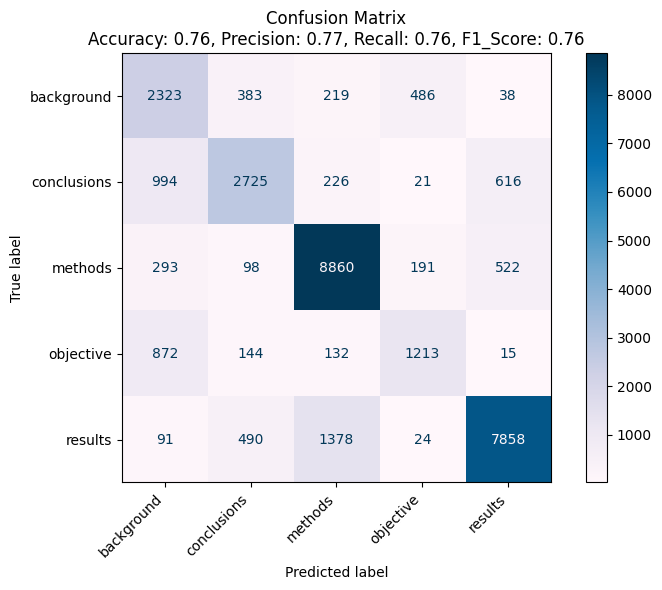

In [58]:
model4_result_val= evaluate_model(y_val, X_pred, class_names= CLASS_NAMES)

## Model Prediction

In [59]:
model4_pred = model4.predict(model4_test_input)
model4_pred = np.argmax(model4_pred, axis=1)

942/942 ━━━━━━━━━━━━━━━━━━━━ 52s 54ms/step



Classification Report
              precision    recall  f1-score   support

  background       0.52      0.68      0.59      3621
 conclusions       0.69      0.59      0.64      4571
     methods       0.81      0.89      0.85      9897
   objective       0.62      0.49      0.55      2333
     results       0.87      0.79      0.83      9713

    accuracy                           0.76     30135
   macro avg       0.70      0.69      0.69     30135
weighted avg       0.76      0.76      0.76     30135


Confusion Matrix


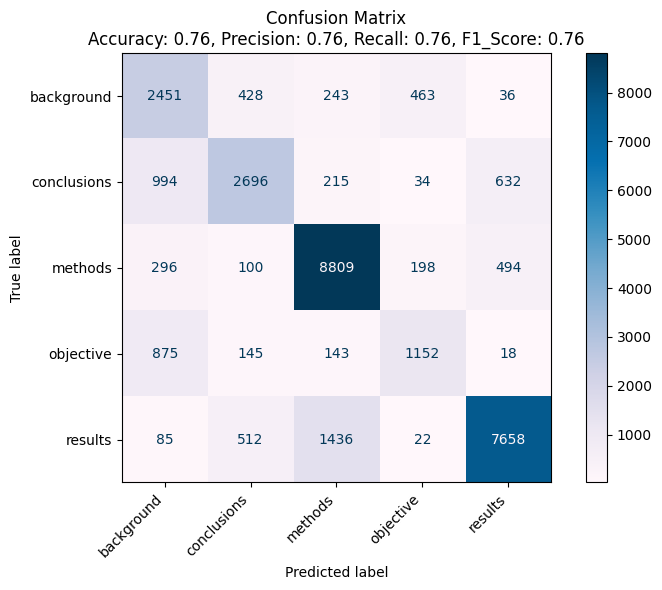

In [60]:
model4_results = evaluate_model(y_test, model4_pred, class_names= CLASS_NAMES)

In [61]:
rnd_id = random.sample(test_df.index.tolist(), 5)

for i in rnd_id:
  print(f'True Label= {test_df.loc[i, "label"]}\nPred Label= {label_encoder.inverse_transform([model4_pred[i]])[0]}\n{test_df.loc[i, "text"]}')
  print()
  print(15*'=')
  print()

True Label= results
Pred Label= results
no suspected hypertensive crises were reported in the trial .


True Label= methods
Pred Label= results
one thousand one hundred ninety-two stemi patients were randomized to receive ses coated with biodegradable ( n = @ ) or durable polymer ( n = @ ) .


True Label= methods
Pred Label= methods
plasma concentrations of irbesartan and hydrochlorothiazide were analyzed by two separate validated liquid chromatography/tandem mass spectrometric ( lc-ms/ms ) methods .


True Label= results
Pred Label= results
specifically , children in the abc group exhibited higher mean ( sd ) log-transformed morning levels than children in the control group ( -@ -lsb- @ -rsb- vs -@ -lsb- @ -rsb- g/dl , respectively -lsb- to convert to nanomoles per liter , multiply by @ -rsb- ; = @ ; p = @ ) .


True Label= results
Pred Label= results
in the control group , the score in the @nd week was not different significantly as compared with that before treatment ( p > @ ) , but

# Model 5: Convolutional Neural Networks

## Building Up The Model

In [62]:
input = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(input)
x = embedding_layer_text(x)
x = tf.keras.layers.Conv1D(64, 5, activation='relu')(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')(x)

model5 = tf.keras.models.Model(inputs=input, outputs=output, name= 'model5_CNN')

model5.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer= tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])

model5.summary()

Model: "model5_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ TokenEmbeddingLayer (Embedding) │ (None, 55, 128)        │     8,299,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 51, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,347,077 (31.84 MB)

 Trainable params: 8,347,077 (31.84 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
callback = ModelCallbacks(verbose=True)
callback.tensorboard(dir_name=DIR_NAME, experiment_name='model5_CNN')
callback.early_stopping(patience=5)

model5_callbacks = callback.get_callbacks()

[TensorBoard] Log files will be saved to: TensorBoard/model5_CNN/20250705-110723
[EarlyStopping] Will stop if no improvement in 'val_loss' for 5 epochs.


In [64]:
model5_train_input = (
    tf.data.Dataset.from_tensor_slices((X_train_text, y_train))
    ).batch(32).prefetch(tf.data.AUTOTUNE)

model5_val_input = (
    tf.data.Dataset.from_tensor_slices((X_val_text, y_val))
    ).batch(32).prefetch(tf.data.AUTOTUNE)

model5_test_input = (
    tf.data.Dataset.from_tensor_slices(X_test_text)
    ).batch(32).prefetch(tf.data.AUTOTUNE)

model5_history = model5.fit(model5_train_input,
                            epochs=3,
                            steps_per_epoch= int(0.05*len(model5_train_input)),
                            validation_data= model5_val_input,
                            validation_steps= int(0.05*len(model5_val_input)),
                            callbacks= model5_callbacks)

Epoch 1/3
281/281 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.6193 - loss: 0.9665 - val_accuracy: 0.7493 - val_loss: 0.6569
Epoch 2/3
281/281 ━━━━━━━━━━━━━━━━━━━━ 41s 146ms/step - accuracy: 0.8297 - loss: 0.5122 - val_accuracy: 0.7487 - val_loss: 0.6753
Epoch 3/3
281/281 ━━━━━━━━━━━━━━━━━━━━ 23s 82ms/step - accuracy: 0.8340 - loss: 0.4972 - val_accuracy: 0.7640 - val_loss: 0.6450
Restoring model weights from the end of the best epoch: 3.


## Model Evaluation

In [65]:
model5.evaluate(model5_val_input)

945/945 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7675 - loss: 0.6414


[0.6465251445770264, 0.767476499080658]

In [66]:
X_pred = model5.predict(model5_val_input)
X_pred = np.argmax(X_pred, axis=1)

945/945 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step



Classification Report
              precision    recall  f1-score   support

  background       0.52      0.71      0.60      3449
 conclusions       0.67      0.66      0.67      4582
     methods       0.85      0.87      0.86      9964
   objective       0.72      0.40      0.51      2376
     results       0.86      0.83      0.84      9841

    accuracy                           0.77     30212
   macro avg       0.72      0.69      0.69     30212
weighted avg       0.78      0.77      0.77     30212


Confusion Matrix


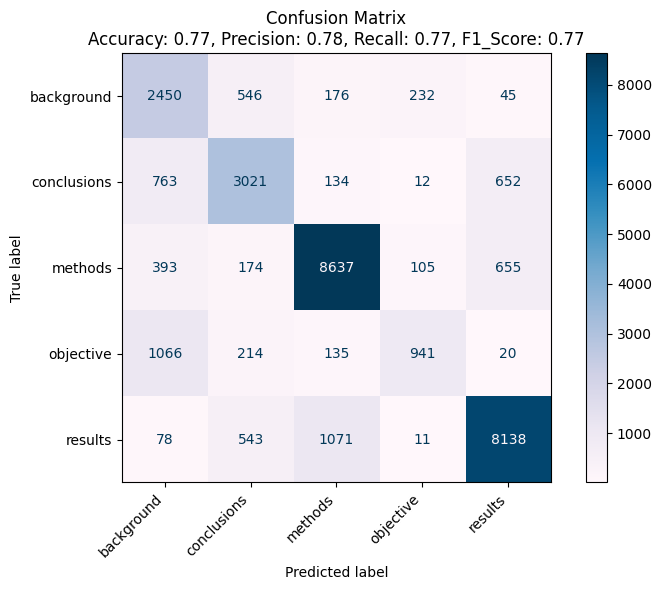

In [67]:
model5_result_val= evaluate_model(y_val, X_pred, class_names= CLASS_NAMES)

## Model Prediction

In [68]:
model5_pred = model5.predict(model5_test_input)
model5_pred = np.argmax(model5_pred, axis=1)

942/942 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step



Classification Report
              precision    recall  f1-score   support

  background       0.53      0.71      0.61      3621
 conclusions       0.67      0.66      0.67      4571
     methods       0.84      0.87      0.86      9897
   objective       0.68      0.39      0.49      2333
     results       0.85      0.82      0.84      9713

    accuracy                           0.76     30135
   macro avg       0.72      0.69      0.69     30135
weighted avg       0.77      0.76      0.76     30135


Confusion Matrix


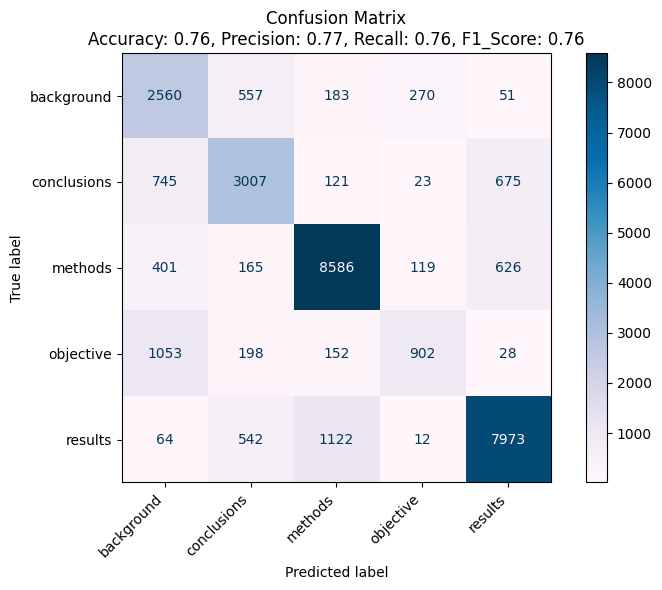

In [69]:
model5_results = evaluate_model(y_test, model5_pred, class_names= CLASS_NAMES)

In [70]:
rnd_id = random.sample(test_df.index.tolist(), 5)

for i in rnd_id:
  print(f'True Label= {test_df.loc[i, "label"]}\nPred Label= {label_encoder.inverse_transform([model5_pred[i]])[0]}\n{test_df.loc[i, "text"]}')
  print()
  print(15*'=')
  print()

True Label= methods
Pred Label= methods
participants were randomly assigned to the intervention and control arms , and analysts were blinded as to participant arm .


True Label= methods
Pred Label= methods
comprehensive safety assessments were performed and efficacy analyses included the proportions of patients in clinical remission ( cd activity index ( cdai ) < @ and no treatment failure ( tf ) ) , and with a clinical response ( @ or @ point cdai reduction from baseline or remission and no tf ) .


True Label= results
Pred Label= results
the median length of hospital stay was @ days for all strategies , and the median time to starting oral treatment was @ days ( interquartile range , @ to @ ) with the fluoroquinolone strategy and @ days ( interquartile range , @ to @ ) with the other strategies .


True Label= background
Pred Label= background
ages are thought to stimulate chronic low-grade inflammation and promote oxidative stress and have been linked to the development of insulin 

# Model 6: Transfer Learning - Universal Sentence Encoder Embedding Layer

## Loading Embeding Layer

In [71]:
import tensorflow_hub as hub
# From https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder#load_the_universal_sentence_encoders_tf_hub_module

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"

hub_use = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                         input_shape=[],
                         dtype=tf.string,
                         trainable=False,
                         name="USE_embedding")

print ("module %s loaded" % module_url)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


## Building Up The Model

In [72]:
inputs = tf.keras.Input(shape=(), dtype= tf.string)
x = tf.keras.layers.Lambda(lambda s:hub_use(s), output_shape= (512,))(inputs)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')(x)

model6 = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='model6_TransferLearning')


model6.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer= tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])

model6.summary()

Model: "model6_TransferLearning"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,077 (137.02 KB)

 Trainable params: 35,077 (137.02 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
callback = ModelCallbacks(verbose=True)
callback.tensorboard(dir_name=DIR_NAME, experiment_name= 'Model6_TransferLearning')
model6_callbacks = callback.get_callbacks()

[TensorBoard] Log files will be saved to: TensorBoard/Model6_TransferLearning/20250705-111037


In [74]:
model6_train_input = (
    tf.data.Dataset.from_tensor_slices((X_train_text, y_train))
    ).batch(32).prefetch(1)

model6_val_input = (
    tf.data.Dataset.from_tensor_slices((X_val_text, y_val))
    ).batch(32).prefetch(1)

model6_test_input = (
    tf.data.Dataset.from_tensor_slices(X_test_text)
    ).batch(32).prefetch(1)


model6_history = model6.fit(model6_train_input,
                            epochs=3,
                            steps_per_epoch= int(0.05*len(model6_train_input)),
                            validation_data= model6_val_input,
                            validation_steps= int(0.05*len(model6_val_input)),
                            callbacks=model6_callbacks)

Epoch 1/3
281/281 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.4709 - loss: 1.3240 - val_accuracy: 0.6469 - val_loss: 0.8759
Epoch 2/3
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6481 - loss: 0.8905 - val_accuracy: 0.6822 - val_loss: 0.8390
Epoch 3/3
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6843 - loss: 0.8341 - val_accuracy: 0.6995 - val_loss: 0.7976


## Model Evaluation

In [75]:
model6.evaluate(model6_val_input)

945/945 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7001 - loss: 0.7784


[0.7795462608337402, 0.6989606618881226]

In [76]:
X_pred = model6.predict(model6_val_input)
X_pred = np.argmax(X_pred, axis=1)

945/945 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step



Classification Report
              precision    recall  f1-score   support

  background       0.48      0.56      0.52      3449
 conclusions       0.62      0.52      0.57      4582
     methods       0.75      0.82      0.78      9964
   objective       0.61      0.43      0.50      2376
     results       0.78      0.78      0.78      9841

    accuracy                           0.70     30212
   macro avg       0.65      0.62      0.63     30212
weighted avg       0.70      0.70      0.70     30212


Confusion Matrix


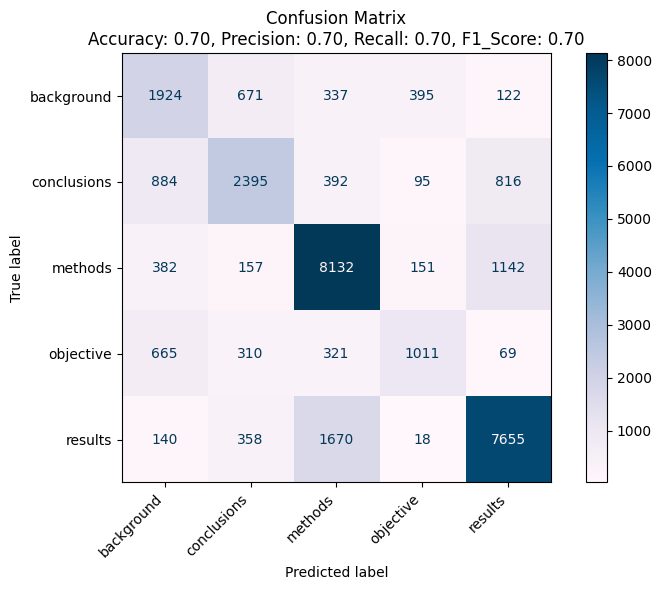

In [77]:
model6_result_val= evaluate_model(y_val, X_pred, class_names= CLASS_NAMES)

## Model Prediction

In [78]:
model6_pred = model6.predict(model6_test_input)
model6_pred = np.argmax(model6_pred, axis=1)

942/942 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step



Classification Report
              precision    recall  f1-score   support

  background       0.50      0.56      0.52      3621
 conclusions       0.60      0.53      0.56      4571
     methods       0.75      0.82      0.78      9897
   objective       0.60      0.43      0.50      2333
     results       0.79      0.77      0.78      9713

    accuracy                           0.70     30135
   macro avg       0.64      0.62      0.63     30135
weighted avg       0.70      0.70      0.69     30135


Confusion Matrix


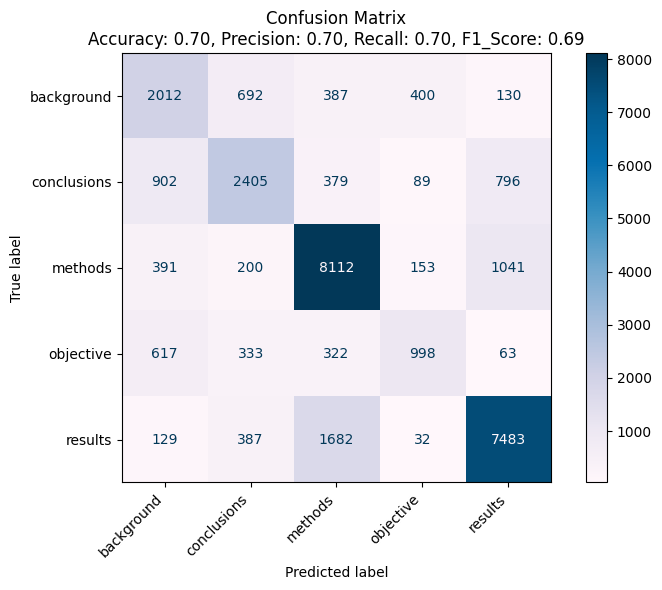

In [79]:
model6_results = evaluate_model(y_test, model6_pred, class_names= CLASS_NAMES)

In [80]:
rnd_id = random.sample(test_df.index.tolist(), 5)

for i in rnd_id:
  print(f'True Label= {test_df.loc[i, "label"]}\nPred Label= {label_encoder.inverse_transform([model6_pred[i]])[0]}\n{test_df.loc[i, "text"]}')
  print()
  print(15*'=')
  print()

True Label= objective
Pred Label= methods
to analyze discordance between global estimates by patients ( patgl ) and their physicians ( docgl ) according to demographic and self-report variables on a multidimensional health assessment questionnaire ( mdhaq ) in patients with many rheumatic diseases seen in usual care .


True Label= objective
Pred Label= objective
to assess the effect of bilateral ultrasound-guided transversus abdominis plane block with ropivacaine compared with placebo as part of a multimodal analgesic regimen .


True Label= methods
Pred Label= background
this trial is registered with the australian new zealand clinical trials registry , number actrn@ ) .


True Label= results
Pred Label= results
successful intubation at first attempt was better ( p < @ ) with group a : @ ( @ % ) while group b : @ ( @ % ) .


True Label= objective
Pred Label= methods
the aim of this single-centre , open-label , prospective , nonsponsored , randomized , controlled clinical trial was to

# Model 7: Character-level Embedding Layer

## Building Up The Model

In [81]:
char_text_vectorizer = tf.keras.layers.TextVectorization(max_tokens = MAX_ALPHABET_LEN, # Number of characters
                                                         output_sequence_length= MAX_LEN_CHAR # Number of characters that cover 95% of sentences
                                                         )

char_text_vectorizer.adapt(X_train_char)

In [82]:
inputs = tf.keras.Input(shape=(), dtype= tf.string)
x = char_text_vectorizer(inputs)
x = tf.keras.layers.Embedding(input_dim=MAX_ALPHABET_LEN,  # Number of different character
                              output_dim=32 # Output dimemsion of embedding space
                              )(x)
x = tf.keras.layers.Conv1D(64, 5, activation='relu')(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')(x)

model7 = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='model7_CharacterEmbedding')


model7.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer= tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])

model7.summary()

Model: "model7_CharacterEmbedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 290)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 290, 32)        │         2,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 286, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_4          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,949 (74.02 KB)

 Trainable params: 18,949 (74.02 KB)

 Non-trainable params: 0 (0.00 B)

In [83]:
callback = ModelCallbacks(verbose=True)
callback.tensorboard(dir_name=DIR_NAME, experiment_name= 'Model7_CharacterEmbedding')
callback.early_stopping(patience=5)
model7_callbacks = callback.get_callbacks()

[TensorBoard] Log files will be saved to: TensorBoard/Model7_CharacterEmbedding/20250705-111150
[EarlyStopping] Will stop if no improvement in 'val_loss' for 5 epochs.


In [84]:
model7_train_input = (
    tf.data.Dataset.from_tensor_slices((X_train_char, y_train))
    ).batch(32).prefetch(tf.data.AUTOTUNE)

model7_val_input = (
    tf.data.Dataset.from_tensor_slices((X_val_char, y_val))
    ).batch(32).prefetch(tf.data.AUTOTUNE)

model7_test_input = (
    tf.data.Dataset.from_tensor_slices(X_test_char)
    ).batch(32).prefetch(tf.data.AUTOTUNE)

model7_history = model7.fit(model7_train_input,
                            epochs=3,
                            steps_per_epoch= int(0.01*len(model7_train_input)),
                            validation_data= model7_val_input,
                            validation_steps= int(0.01*len(model7_val_input)),
                            callbacks=model7_callbacks)

Epoch 1/3
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.3169 - loss: 1.5483 - val_accuracy: 0.4062 - val_loss: 1.4648
Epoch 2/3
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.3489 - loss: 1.4634 - val_accuracy: 0.4028 - val_loss: 1.4149
Epoch 3/3
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.3772 - loss: 1.4008 - val_accuracy: 0.4410 - val_loss: 1.3132
Restoring model weights from the end of the best epoch: 3.


## Model Evaluation

In [85]:
model7.evaluate(model7_val_input)

945/945 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.4367 - loss: 1.2953


[1.2955390214920044, 0.43495962023735046]

In [86]:
X_pred = model7.predict(model7_val_input)
X_pred = np.argmax(X_pred, axis=1)

945/945 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Classification Report
              precision    recall  f1-score   support

  background       0.21      0.01      0.02      3449
 conclusions       0.00      0.00      0.00      4582
     methods       0.42      0.94      0.58      9964
   objective       0.00      0.00      0.00      2376
     results       0.47      0.38      0.42      9841

    accuracy                           0.43     30212
   macro avg       0.22      0.27      0.21     30212
weighted avg       0.32      0.43      0.33     30212


Confusion Matrix


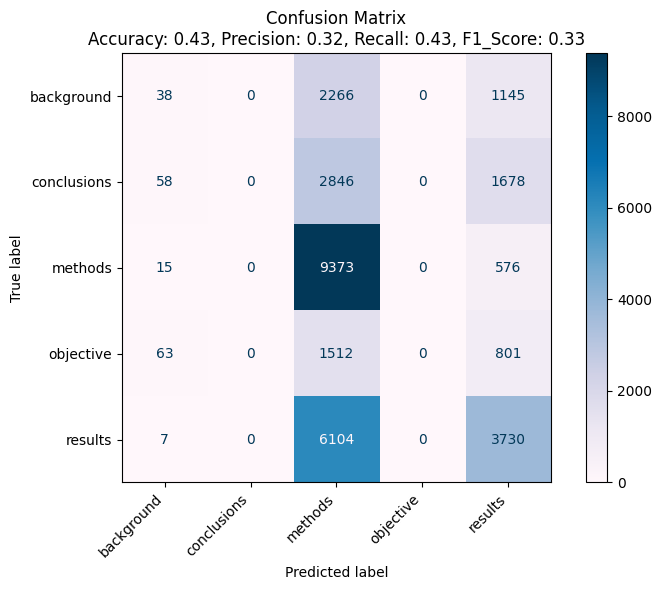

In [87]:
model7_result_val= evaluate_model(y_val, X_pred, class_names= CLASS_NAMES)

## Model Prediction

In [88]:
model7_pred = model7.predict(model7_test_input)
model7_pred = np.argmax(model7_pred, axis=1)

942/942 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Classification Report
              precision    recall  f1-score   support

  background       0.30      0.01      0.03      3621
 conclusions       0.00      0.00      0.00      4571
     methods       0.42      0.94      0.58      9897
   objective       0.00      0.00      0.00      2333
     results       0.46      0.37      0.41      9713

    accuracy                           0.43     30135
   macro avg       0.24      0.27      0.20     30135
weighted avg       0.32      0.43      0.33     30135


Confusion Matrix


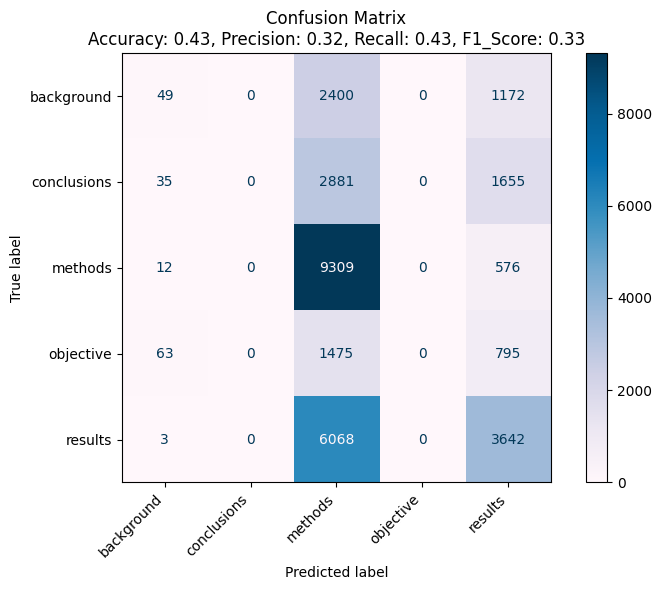

In [89]:
model7_results = evaluate_model(y_test, model7_pred, class_names= CLASS_NAMES)

In [90]:
rnd_id = random.sample(test_df.index.tolist(), 5)

for i in rnd_id:
  print(f'True Label= {test_df.loc[i, "label"]}\nPred Label= {label_encoder.inverse_transform([model7_pred[i]])[0]}\n{test_df.loc[i, "text"]}')
  print()
  print(15*'=')
  print()

True Label= objective
Pred Label= results
to compare the efficacy differences between acupuncture-moxibustion and physiotherapy interventions in improving proprioception of athletes with lateral collateral ligament injury of the ankle joint .


True Label= methods
Pred Label= methods
a convenience sample of patients aged @ to @ years with acute abdominal , flank , low back , or extremity pain were enrolled .


True Label= background
Pred Label= methods
for smoking pharmacotherapies , guessing enrollment in the active medication treatment is associated with higher abstinence rates .


True Label= methods
Pred Label= methods
primary outcomes were knowledge , satisfaction , decision conflict , distress , and quality of life ; secondary outcomes were equivalence of brca@/@ test uptake and costs of delivering tc versus uc .


True Label= methods
Pred Label= methods
baseline dietary intake and measures of the mini-mental state examination were recorded in @,@ men and women who were enrolled 

# Model 8: Combination of Char-level Embeding and Token-level Embedding

## Building Up The Model

In [91]:
# Token-Level:
token_input = tf.keras.Input(shape=(), dtype= tf.string, name= 'TokenInput') # using precomputed embedding data with USE - like Model 6
x_text = tf.keras.layers.Lambda(lambda s: hub_use(s), output_shape= (512,))(token_input)
x_text = tf.keras.layers.Dense(64, activation='relu')(x_text)
x_text = tf.keras.layers.Dropout(0.2)(x_text)
token_output = tf.keras.layers.Dense(32, activation='relu')(x_text)
token_model = tf.keras.models.Model(inputs=token_input, outputs=token_output, name='Model8_token_model')

# Char-Level:
char_input = tf.keras.Input(shape=(), dtype= tf.string, name= 'CharInput') # like Model 7
x_char = char_text_vectorizer(char_input)
x_char = tf.keras.layers.Embedding(input_dim=MAX_ALPHABET_LEN , output_dim=32)(x_char)
x_char = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(x_char)
char_output = tf.keras.layers.Dense(32, activation='relu')(x_char)
char_model = tf.keras.models.Model(inputs=char_input, outputs=char_output, name='Model8_char_model')

# Concatenate TOKEN and CHAR input - Hybrid Token Embedding
token_char_concat = tf.keras.layers.Concatenate(name = 'HybridToken')([token_model.output,
                                                                       char_model.output])
x = tf.keras.layers.Dense(64, activation='relu')(token_char_concat)
x = tf.keras.layers.Dropout(0.2)(x)
hybrid_output = tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')(x)

model8 = tf.keras.models.Model(inputs=[token_model.input, char_model.input],
                               outputs=hybrid_output,
                               name='Model8_Hybrid')

model8.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer= tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])

model8.summary()

Model: "Model8_Hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ TokenInput          │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CharInput           │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 512)       │          0 │ TokenInput[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization… │ (None, 290)       │          0 │ CharInput[0][0]   │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 64)        │     32,832 │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 290, 32)   │      2,240 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64)        │          0 │ dense_21[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 48)        │     10,944 │ embedding_1[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 32)        │      2,080 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 32)        │      1,568 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ HybridToken         │ (None, 64)        │          0 │ dense_22[0][0],   │
│ (Concatenate)       │                   │            │ dense_23[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 64)        │      4,160 │ HybridToken[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 64)        │          0 │ dense_24[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 5)         │        325 │ dropout_15[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,149 (211.52 KB)

 Trainable params: 54,149 (211.52 KB)

 Non-trainable params: 0 (0.00 B)

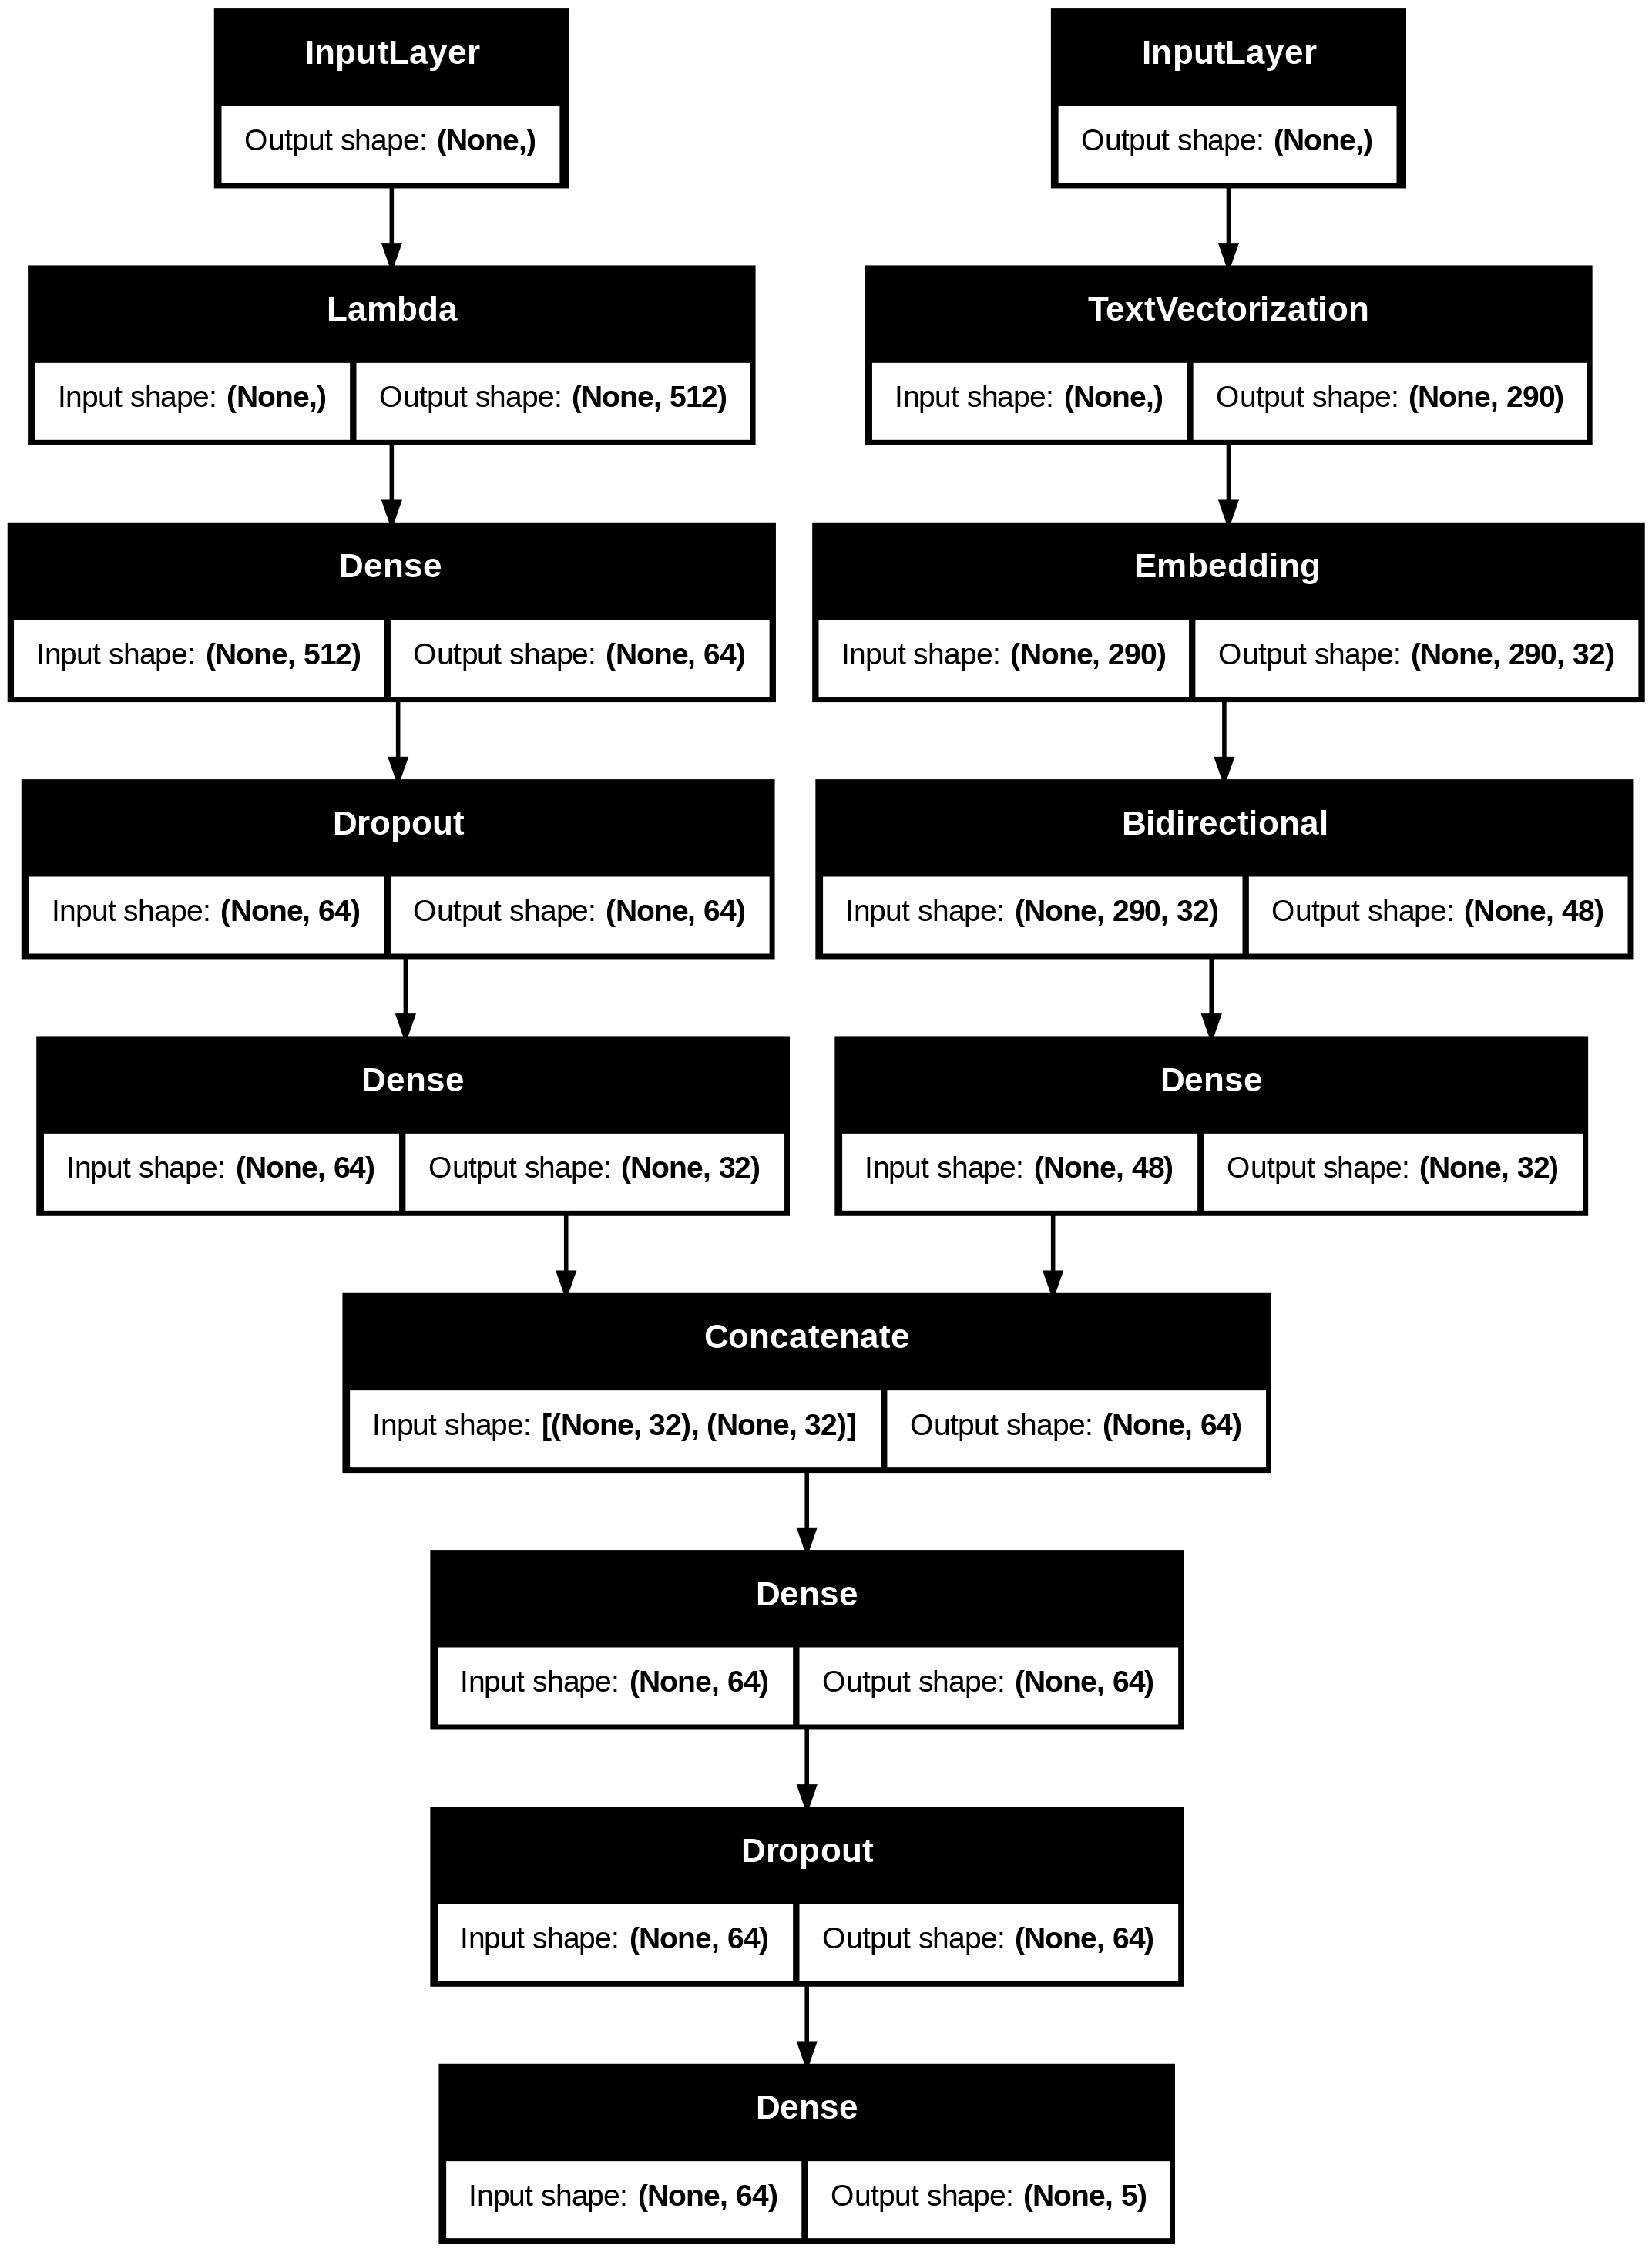

In [92]:
tf.keras.utils.plot_model(model8, show_shapes=True)

In [93]:
callback = ModelCallbacks(verbose=True)
callback.tensorboard(dir_name=DIR_NAME, experiment_name= 'Model8_Hybrid')
callback.early_stopping(patience=5)
model8_callbacks = callback.get_callbacks()

[TensorBoard] Log files will be saved to: TensorBoard/Model8_Hybrid/20250705-111227
[EarlyStopping] Will stop if no improvement in 'val_loss' for 5 epochs.


In [94]:
model8_train_input = (
    tf.data.Dataset.from_tensor_slices(
        ({'TokenInput': X_train_text, 'CharInput': X_train_char}, y_train)
        )
    ).batch(32).prefetch(tf.data.AUTOTUNE)

model8_val_input = (
    tf.data.Dataset.from_tensor_slices(
        ({'TokenInput': X_val_text, 'CharInput': X_val_char}, y_val)
        )
    ).batch(32).prefetch(tf.data.AUTOTUNE)

model8_test_input = (
    tf.data.Dataset.from_tensor_slices(
        {'TokenInput': X_test_text, 'CharInput': X_test_char}
        )
    ).batch(32).prefetch(tf.data.AUTOTUNE)



model8_history = model8.fit(model8_train_input,
                            epochs=3,
                            steps_per_epoch= int(0.01*len(model8_train_input)),
                            validation_data= model8_val_input,
                            validation_steps= int(0.01*len(model8_val_input)),
                            callbacks=model8_callbacks)

Epoch 1/3
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 226ms/step - accuracy: 0.3064 - loss: 1.5496 - val_accuracy: 0.3576 - val_loss: 1.3757
Epoch 2/3
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step - accuracy: 0.4755 - loss: 1.2974 - val_accuracy: 0.5729 - val_loss: 1.0162
Epoch 3/3
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 203ms/step - accuracy: 0.5896 - loss: 1.0110 - val_accuracy: 0.6076 - val_loss: 0.9361
Restoring model weights from the end of the best epoch: 3.


## Model Evaluation

In [95]:
model8.evaluate(model8_val_input)

945/945 ━━━━━━━━━━━━━━━━━━━━ 50s 53ms/step - accuracy: 0.6200 - loss: 0.9078


[0.9084229469299316, 0.6183635592460632]

In [96]:
X_pred = model8.predict(model8_val_input)
X_pred = np.argmax(X_pred, axis=1)

945/945 ━━━━━━━━━━━━━━━━━━━━ 46s 48ms/step



Classification Report
              precision    recall  f1-score   support

  background       0.33      0.73      0.45      3449
 conclusions       0.55      0.14      0.23      4582
     methods       0.69      0.84      0.76      9964
   objective       1.00      0.00      0.00      2376
     results       0.78      0.73      0.75      9841

    accuracy                           0.62     30212
   macro avg       0.67      0.49      0.44     30212
weighted avg       0.68      0.62      0.58     30212


Confusion Matrix


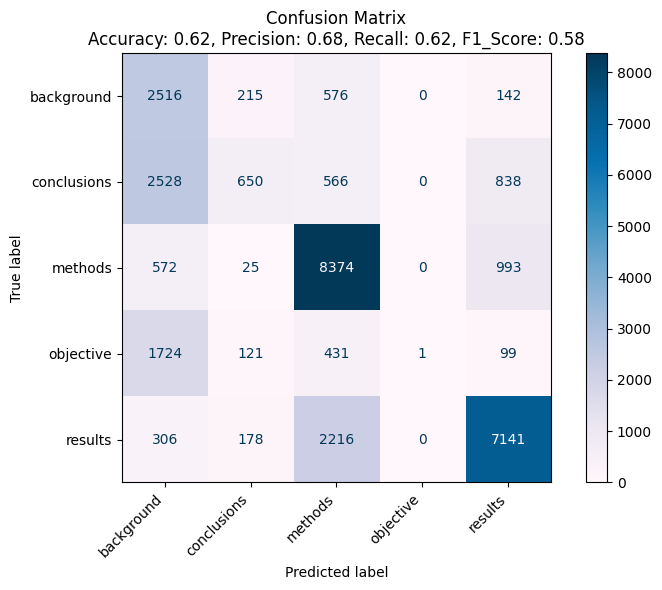

In [97]:
model8_result_val= evaluate_model(y_val, X_pred, class_names= CLASS_NAMES)

## Model Prediction

In [100]:
model8_pred = model8.predict(model8_test_input)
model8_pred = np.argmax(model8_pred, axis=1)

942/942 ━━━━━━━━━━━━━━━━━━━━ 64s 67ms/step



Classification Report
              precision    recall  f1-score   support

  background       0.34      0.73      0.46      3621
 conclusions       0.55      0.14      0.23      4571
     methods       0.69      0.84      0.76      9897
   objective       1.00      0.00      0.00      2333
     results       0.78      0.72      0.75      9713

    accuracy                           0.62     30135
   macro avg       0.67      0.49      0.44     30135
weighted avg       0.68      0.62      0.58     30135


Confusion Matrix


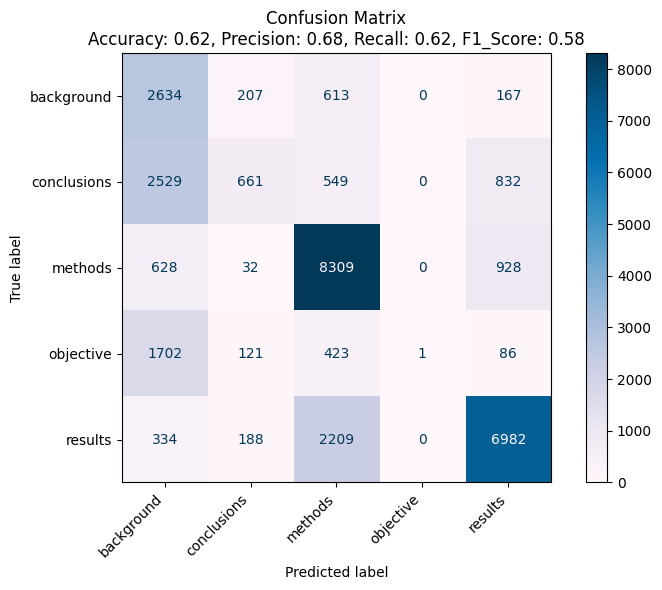

In [101]:
model8_results = evaluate_model(y_test, model8_pred, class_names= CLASS_NAMES)

In [102]:
rnd_id = random.sample(test_df.index.tolist(), 5)

for i in rnd_id:
  print(f'True Label= {test_df.loc[i, "label"]}\nPred Label= {label_encoder.inverse_transform([model8_pred[i]])[0]}\n{test_df.loc[i, "text"]}')
  print()
  print(15*'=')
  print()

True Label= conclusions
Pred Label= background
these data support the clinical benefits and acceptable safety profile of lenalidomide in transfusion-dependent patients with ipss-defined low - / int-@-risk mds with isolated del ( @q ) .


True Label= methods
Pred Label= methods
this study used a randomized controlled clinical trial involving two unique hand-off approaches and a convenience sample .


True Label= methods
Pred Label= results
a single numeric hrm score that reflects hiv diversity was generated for each region ; composite hrm scores were also calculated ( mean and median for all six regions ) .


True Label= results
Pred Label= results
no significant difference was seen between pre-se scores of intervention ( @ @ ) and control ( @ @ ) groups ( t = @ , p = @ ) .


True Label= objective
Pred Label= conclusions
however , low response rates may contribute to nonresponse bias .




# Model 9: Model 8 with Positional Embedding

## Building Up The Model

In [103]:
# Token Embedding:
token_input = tf.keras.Input(shape=(), dtype=tf.string, name= 'TokenInput') # using precomputed embedding data with USE - like Model 6
x_text = tf.keras.layers.Lambda(lambda s: hub_use(s), output_shape= (512,))(token_input)
x_text = tf.keras.layers.Dense(64, activation='relu')(x_text)
x_text = tf.keras.layers.Dropout(0.2)(x_text)
token_output = tf.keras.layers.Dense(32, activation='relu')(x_text)
token_model = tf.keras.models.Model(inputs=token_input, outputs=token_output, name='Model9_token_model')

# Charecter-level Embedding:
char_input = tf.keras.Input(shape=(), dtype= tf.string, name= 'CharInput') # like Model 7
x_char = char_text_vectorizer(char_input)
x_char = tf.keras.layers.Embedding(input_dim=MAX_LEN_CHAR, output_dim=64)(x_char)
char_output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(x_char)
char_model = tf.keras.models.Model(inputs=char_input, outputs=char_output, name='Model9_char_model')

# Total-line in Consideration:
tl_input = tf.keras.Input(shape=(), dtype= tf.int32, name= 'TotalLineInput')
x_tl = tf.keras.layers.Lambda(
    lambda x: tf.one_hot(x, depth=MAX_TOTAL_LINES),
    output_shape=(MAX_TOTAL_LINES,),
    name="TotalLineOneHotEncoding"
    )(tl_input)
x_tl = tf.keras.layers.Dense(64, activation='relu')(x_tl)
x_tl = tf.keras.layers.Dropout(0.2)(x_tl)
total_line_output = tf.keras.layers.Dense(32, activation='relu')(x_tl)
total_line_model = tf.keras.models.Model(inputs=tl_input, outputs=total_line_output, name='Model9_total_line_model')

# Line-Nmber in Consideration:
ln_input = tf.keras.Input(shape=(), dtype=tf.int32, name= 'LineNumberInput')
x_ln = tf.keras.layers.Lambda(
    lambda x: tf.one_hot(x, depth=MAX_NUM_LINES),
    output_shape=(MAX_NUM_LINES,),
    name="LineNumOneHotEncoding"
    )(ln_input)
x_ln = tf.keras.layers.Dense(64, activation='relu')(x_ln)
x_ln = tf.keras.layers.Dropout(0.2)(x_ln)
line_number_output = tf.keras.layers.Dense(32, activation='relu')(x_ln)
line_number_model = tf.keras.models.Model(inputs=ln_input, outputs=line_number_output, name='Model9_line_number_model')

# Concatenate Above Models and Building Model 9:
concat_layer1 = tf.keras.layers.Concatenate(name = 'ConcatLayer1')([
    token_model.output,
    char_model.output
    ])

x1 = tf.keras.layers.Dense(512, activation='relu')(concat_layer1)
x1 = tf.keras.layers.Dropout(0.5)(x1)

concate_layer2 = tf.keras.layers.Concatenate(name= 'ConcatLayer2')(
    [total_line_model.output,
     line_number_model.output,
     x1]
)


hybrid_output = tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')(concate_layer2)
model9 = tf.keras.models.Model(inputs=[token_model.input, char_model.input, total_line_model.input, line_number_model.input],
                               outputs=hybrid_output,
                               name='Model9_Hybrid')

model9.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer= tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])

model9.summary()

Model: "Model9_Hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ TokenInput          │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 512)       │          0 │ TokenInput[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CharInput           │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 64)        │     32,832 │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization… │ (None, 290)       │          0 │ CharInput[0][0]   │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ TotalLineInput      │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LineNumberInput     │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 64)        │          0 │ dense_26[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 290, 64)   │     18,560 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ TotalLineOneHotEnc… │ (None, 19)        │          0 │ TotalLineInput[0… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LineNumOneHotEncod… │ (None, 14)        │          0 │ LineNumberInput[… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 32)        │      2,080 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 64)        │     24,832 │ embedding_2[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 64)        │      1,280 │ TotalLineOneHotE… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 64)        │        960 │ LineNumOneHotEnc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ConcatLayer1        │ (None, 96)        │          0 │ dense_27[0][0],   │
│ (Concatenate)       │                   │            │ bidirectional_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 64)        │          0 │ dense_28[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 64)        │          0 │ dense_30[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 137,253 (536.14 KB)

 Trainable params: 137,253 (536.14 KB)

 Non-trainable params: 0 (0.00 B)

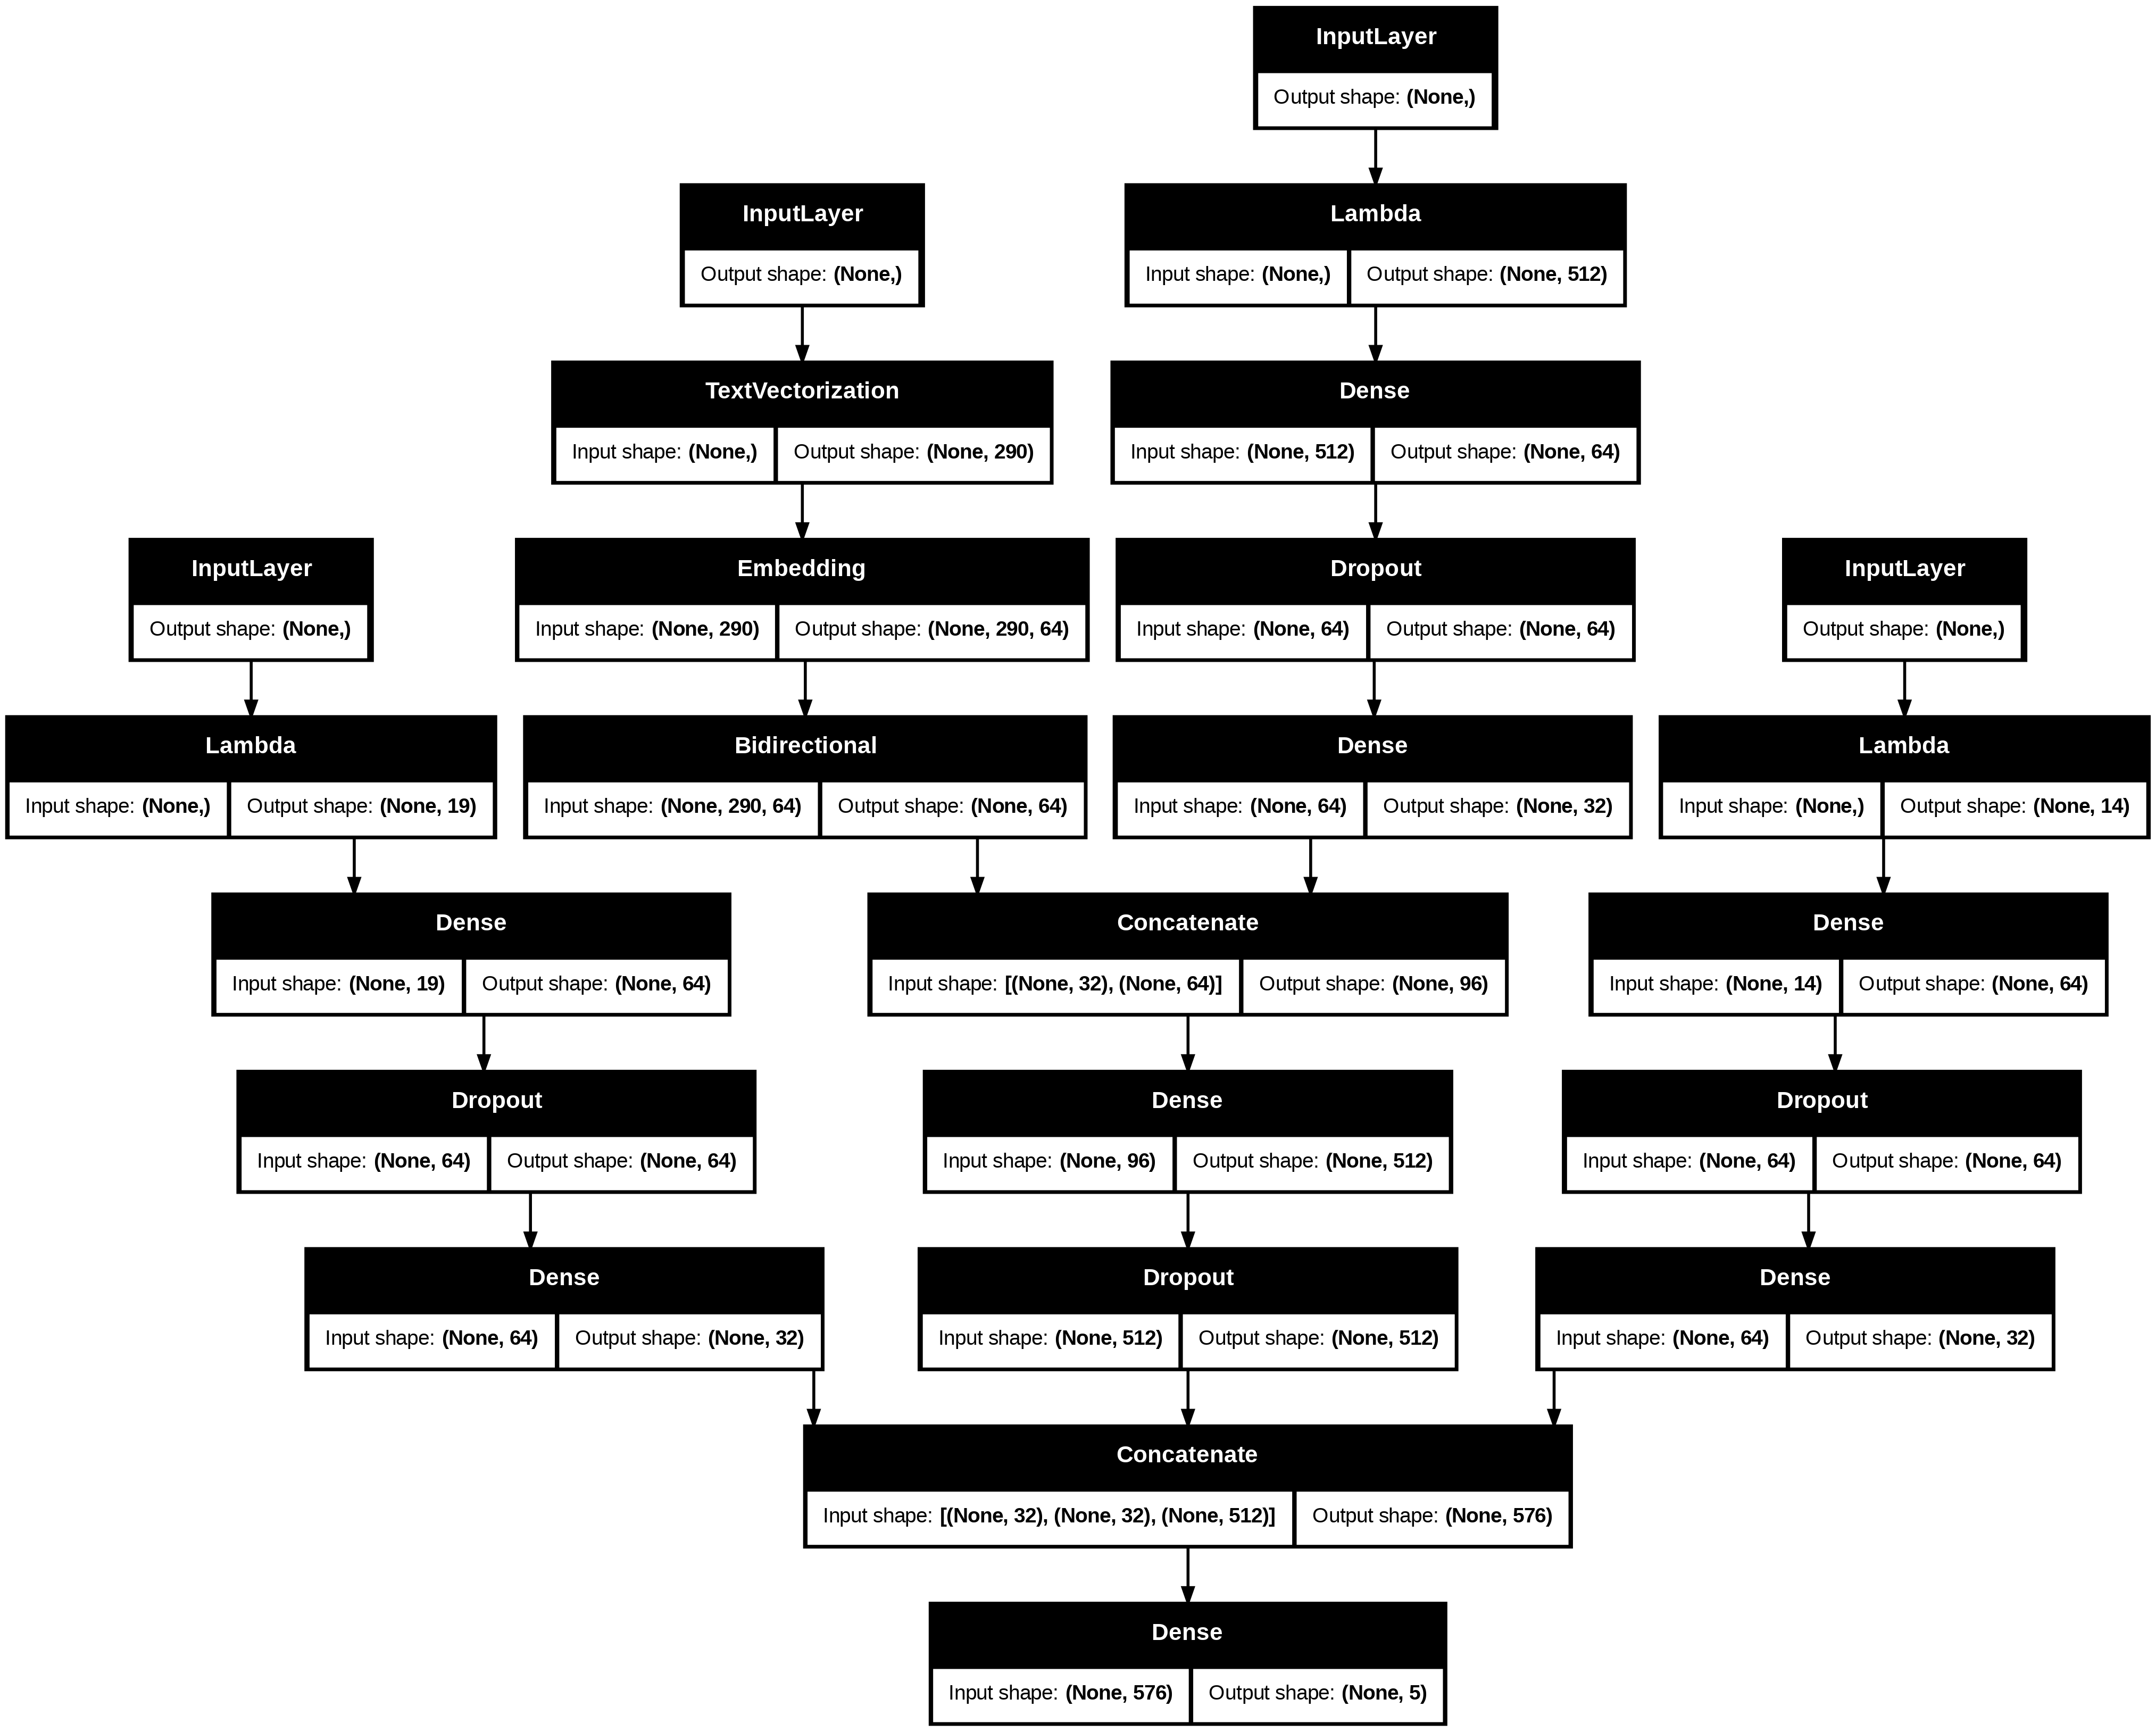

In [104]:
tf.keras.utils.plot_model(model9, show_shapes=True)

In [105]:
callback = ModelCallbacks(verbose=True)
callback.tensorboard(dir_name=DIR_NAME, experiment_name= 'Model9_Hybrid')
callback.early_stopping(patience=5)
model9_callbacks = callback.get_callbacks()

[TensorBoard] Log files will be saved to: TensorBoard/Model9_Hybrid/20250705-111957
[EarlyStopping] Will stop if no improvement in 'val_loss' for 5 epochs.


In [106]:
model9_train_input = tf.data.Dataset.from_tensor_slices(
    ({'TokenInput': X_train_text, 'CharInput': X_train_char, 'TotalLineInput': X_train_tl, 'LineNumberInput': X_train_ln}, y_train)
    ).batch(32).prefetch(tf.data.AUTOTUNE)

model9_val_input = tf.data.Dataset.from_tensor_slices(
    ({'TokenInput': X_val_text, 'CharInput': X_val_char, 'TotalLineInput': X_val_tl, 'LineNumberInput': X_val_ln}, y_val)
    ).batch(32).prefetch(tf.data.AUTOTUNE)


model9_test_input = tf.data.Dataset.from_tensor_slices(
    ({'TokenInput': X_test_text, 'CharInput': X_test_char, 'TotalLineInput': X_test_tl, 'LineNumberInput': X_test_ln})
    ).batch(32).prefetch(tf.data.AUTOTUNE)

model9_history = model9.fit(model9_train_input,
                            epochs=3,
                            steps_per_epoch= int(0.05*len(model9_train_input)),
                            validation_data= model9_val_input,
                            validation_steps= int(0.05*len(model9_val_input)),
                            callbacks=model9_callbacks)

Epoch 1/3
281/281 ━━━━━━━━━━━━━━━━━━━━ 74s 234ms/step - accuracy: 0.5286 - loss: 1.1554 - val_accuracy: 0.7779 - val_loss: 0.5821
Epoch 2/3
281/281 ━━━━━━━━━━━━━━━━━━━━ 82s 292ms/step - accuracy: 0.7702 - loss: 0.5796 - val_accuracy: 0.7912 - val_loss: 0.5413
Epoch 3/3
281/281 ━━━━━━━━━━━━━━━━━━━━ 82s 292ms/step - accuracy: 0.8066 - loss: 0.5126 - val_accuracy: 0.8072 - val_loss: 0.4900
Restoring model weights from the end of the best epoch: 3.


## Model Evaluation

In [107]:
model9.evaluate(model9_val_input)

945/945 ━━━━━━━━━━━━━━━━━━━━ 54s 57ms/step - accuracy: 0.8131 - loss: 0.4758


[0.4784640669822693, 0.8125247955322266]

In [108]:
X_pred = model9.predict(model9_val_input)
X_pred = np.argmax(X_pred, axis=1)

945/945 ━━━━━━━━━━━━━━━━━━━━ 54s 56ms/step



Classification Report
              precision    recall  f1-score   support

  background       0.61      0.91      0.73      3449
 conclusions       0.84      0.81      0.82      4582
     methods       0.86      0.86      0.86      9964
   objective       0.92      0.33      0.48      2376
     results       0.85      0.85      0.85      9841

    accuracy                           0.81     30212
   macro avg       0.82      0.75      0.75     30212
weighted avg       0.83      0.81      0.81     30212


Confusion Matrix


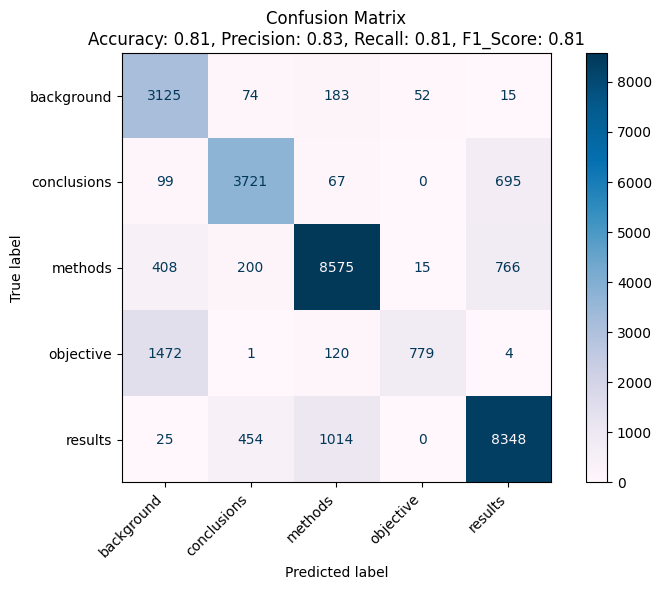

In [109]:
model9_result_val= evaluate_model(y_val, X_pred, class_names= CLASS_NAMES)

## Model Prediction

In [110]:
model9_pred = model9.predict(model9_test_input)
model9_pred = np.argmax(model9_pred, axis=1)

942/942 ━━━━━━━━━━━━━━━━━━━━ 53s 55ms/step



Classification Report
              precision    recall  f1-score   support

  background       0.63      0.90      0.74      3621
 conclusions       0.82      0.82      0.82      4571
     methods       0.86      0.86      0.86      9897
   objective       0.90      0.33      0.49      2333
     results       0.85      0.84      0.85      9713

    accuracy                           0.81     30135
   macro avg       0.81      0.75      0.75     30135
weighted avg       0.83      0.81      0.81     30135


Confusion Matrix


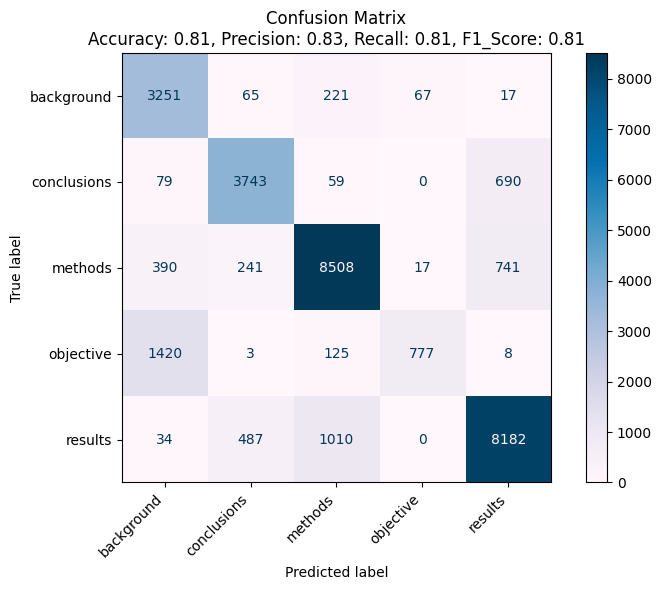

In [111]:
model9_results = evaluate_model(y_test, model9_pred, class_names= CLASS_NAMES)

In [112]:
rnd_id = random.sample(test_df.index.tolist(), 5)

for i in rnd_id:
  print(f'True Label= {test_df.loc[i, "label"]}\nPred Label= {label_encoder.inverse_transform([model9_pred[i]])[0]}\n{test_df.loc[i, "text"]}')
  print()
  print(15*'=')
  print()

True Label= background
Pred Label= background
wound infiltration at the end of carotid endarterectomy under general anaesthesia is a simple technique that can be delegated to the surgeon .


True Label= results
Pred Label= results
a total of @ participants from @ centers were included : @ in the wbv plus exercise group and @ in the control group .


True Label= results
Pred Label= results
cpap reduced ess by @ points ( @ % ci -@ to -@ ; p < @ ) at @ months for @ ( @ % ) of @ patients compared with @ ( @ % ) of @ patients given bsc , and by @ points ( -@ to -@ ; p < @ ) at @ months for @ patients compared with @ patients given bsc .


True Label= background
Pred Label= background
noting that cerebral oxygenation levels often fell below recommended levels , the authors sought to measure the effects of hypotensive versus standard anesthesia on blood transfusion rates .


True Label= results
Pred Label= results
peak skin perfusion was @ % @ % and @ % @ % at baseline for @ - and @-ma intens